In [16]:
# BMED Autoregressive Model - Pretrained Model Loading and Testing
# Í∏∞Ï°¥ ÌïôÏäµÎêú Î™®Îç∏(BMED_TF_250816.pth)ÏùÑ Î∂àÎü¨ÏôÄÏÑú Ïù∏Í≥µÏã†Í≤ΩÎßù Î™®Îç∏ Íµ¨Ï∂ï

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence, PackedSequence
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import math
import numpy as np
import matplotlib.pyplot as plt

print("üöÄ BMED Autoregressive Model - Pretrained Model Loading")
print("üìÅ Target model file: BMED_TF_250816.pth")
print("="*60)

üöÄ BMED Autoregressive Model - Pretrained Model Loading
üìÅ Target model file: BMED_TF_250816.pth


In [17]:
# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Ìï®ÏàòÎì§
def df_treat(name):
    """Îç∞Ïù¥ÌÑ∞ Ï†ïÍ∑úÌôî Î∞è Ï†ÑÏ≤òÎ¶¨"""
    df = pd.read_csv(name)
    ndf = pd.DataFrame()
    range_mm={
        'V': {'min':df['V'].min()*0.8, 'max': df['V'].max()*1.2},
        'E': {'min':df['E'].min()*0.8, 'max': df['E'].max()*1.2},
        'VF': {'min':df['VF'].min()*0.8, 'max': df['VF'].max()*1.2},
        'VA': {'min':df['VA'].min()*0.8, 'max': df['VA'].max()*1.2},
        'VB': {'min':df['VB'].min()*0.8, 'max': df['VB'].max()*1.2},
        'CFLA': {'min':0, 'max': df['CFLA'].max()*1.2},
        'CALA': {'min':0, 'max': df['CALA'].max()*1.2},
        'CFK': {'min':0, 'max': df['CFK'].max()*1.2},
        'CBK': {'min':0, 'max': df['CBK'].max()*1.2},
        'I': {'min':0, 'max': df['I'].max()*1.2},
    }
    ndf['exp'] = df['exp']; ndf['t'] = df['t']

    for col in ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']:
        if col in range_mm:
            ndf[col] = (df[col] - range_mm[col]['min'])/(range_mm[col]['max'] - range_mm[col]['min'])
        else:
            ndf[col] = df[col]

    exp_num_list = sorted(ndf['exp'].unique())
    return df, ndf, range_mm, exp_num_list

def seq_data(ndf, exp_num_list):
    """ÏãúÌÄÄÏä§ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±"""
    seq = []
    feature_cols = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
    
    for exp in exp_num_list:
        exp_df = ndf[ndf['exp'] == exp]
        seq.append(exp_df[feature_cols].values)
    
    return seq

def pad_seq(seq):
    """ÏãúÌÄÄÏä§ Ìå®Îî©"""
    max_len = max([len(s) for s in seq])
    seq_len = [len(s) for s in seq]
    pad_seq = pad_sequence([torch.tensor(s) for s in seq], batch_first=True, padding_value=-1)
    return pad_seq, seq_len, max_len

def gen_dataset(pad_seq, seq_len):
    """Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±"""
    input_tensor = pad_seq.float()
    seq_len_tensor = torch.tensor(seq_len)
    dataset = TensorDataset(input_tensor, seq_len_tensor)
    return dataset

In [18]:
# Î™®Îç∏ ÌÅ¥ÎûòÏä§ Ï†ïÏùò (Í∏∞Ï°¥ ÌïôÏäµÎêú Î™®Îç∏Í≥º ÎèôÏùºÌïú Íµ¨Ï°∞)

class LayerNormLSTM(nn.Module):
    """LSTM layer with layer normalization applied to gates"""
    def __init__(self, input_node, hidden_node):
        super().__init__()
        self.input_node = input_node
        self.hidden_node = hidden_node

        self.w_i = nn.Linear(input_node, 4 * hidden_node, bias=False)
        self.w_h = nn.Linear(hidden_node, 4 * hidden_node, bias=False)

        self.ln_i = nn.LayerNorm(hidden_node)
        self.ln_h = nn.LayerNorm(hidden_node)
        self.ln_g = nn.LayerNorm(hidden_node)
        self.ln_o = nn.LayerNorm(hidden_node)

        self.ln_c = nn.LayerNorm(hidden_node)

    def forward(self, input, hidden):
        h_prev, c_prev = hidden

        gi = self.w_i(input)
        gh = self.w_h(h_prev)
        i_i, i_f, i_g, i_o = gi.chunk(4, dim=-1)
        h_i, h_f, h_g, h_o = gh.chunk(4, dim=-1)

        i_g = torch.sigmoid(self.ln_i(i_i + h_i))
        f_g = torch.sigmoid(self.ln_h(i_f + h_f))
        g_g = torch.tanh(self.ln_g(i_g + h_g))
        o_g = torch.sigmoid(self.ln_o(i_o + h_o))

        c_new = f_g * c_prev + i_g * g_g
        c_new = self.ln_c(c_new)

        h_new = o_g * torch.tanh(c_new)

        return h_new, c_new

class StateExtr(nn.Module):
    """State Extractor using LayerNorm LSTM"""
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        self.hidden_node = hidden_node
        self.n_layer = n_layer
        self.input_node = input_node

        self.lstm_cells = nn.ModuleList()
        self.lstm_cells.append(LayerNormLSTM(input_node, hidden_node))

        for _ in range(n_layer - 1):
            self.lstm_cells.append(LayerNormLSTM(hidden_node, hidden_node))

        self.dropout = nn.Dropout(dropout)
        self.final_layer_norm = nn.LayerNorm(hidden_node)
        self.final_dropout = nn.Dropout(dropout)

    def forward(self, x, seq_len):
        batch_size, max_len, input_node = x.size()
        device = x.device

        h_states = []
        c_states = []
        for _ in range(self.n_layer):
            h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
            c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
        
        outputs = []
        for t in range(max_len):
            x_t = x[:, t, :]

            layer_input = x_t
            for layer_idx, lstm_cell in enumerate(self.lstm_cells):
                h_new, c_new = lstm_cell(layer_input, (h_states[layer_idx], c_states[layer_idx]))

                h_states[layer_idx] = h_new
                c_states[layer_idx] = c_new

                if layer_idx < len(self.lstm_cells) - 1:
                    layer_input = self.dropout(h_new)
                else:
                    layer_input = h_new

            outputs.append(layer_input)
        
        output_tensor = torch.stack(outputs, dim=1)
        seq_len_cpu = seq_len.detach().cpu().long()
        mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
        mask = mask.float().to(device).unsqueeze(-1)

        masked_output = output_tensor * mask
        normalized = self.final_layer_norm(masked_output)
        return self.final_dropout(normalized)

In [19]:
class PhysicalChangeDecoder(nn.Module):
    """Physical Change Decoder"""
    def __init__(self, input_node, output_node, n_layer, hidden_node, dropout):
        super().__init__()

        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(input_node, hidden_node))
        self.layers.append(nn.LayerNorm(hidden_node))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        for i in range(n_layer - 1):
            self.layers.append(nn.Linear(hidden_node, hidden_node))
            self.layers.append(nn.LayerNorm(hidden_node))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))

        self.layers.append(nn.Linear(hidden_node, output_node))
    
    def forward(self, hidden_states):
        x = hidden_states
        for layer in self.layers:
            x = layer(x)
        return x

class CurrentPredictor(nn.Module):
    """Current Predictor"""
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(input_node, hidden_node))
        self.layers.append(nn.LayerNorm(hidden_node))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))
        
        for i in range(n_layer - 1):
            self.layers.append(nn.Linear(hidden_node, hidden_node))
            self.layers.append(nn.LayerNorm(hidden_node))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))
        
        self.layers.append(nn.Linear(hidden_node, 1))
    
    def forward(self, new_state):
        x = new_state
        for layer in self.layers:
            x = layer(x)
        return x

In [20]:
class PhysicsConstraintLayer(nn.Module):
    """Physics Constraint Layer with Current Prediction"""
    def __init__(self, range_mm, current_predictor, eps=1e-2):
        super().__init__()
        self.sps = eps
        self.current_predictor = current_predictor
        self.register_buffer('range_mm_tensor', self._convert_range_to_tensor(range_mm))

    def _convert_range_to_tensor(self, range_mm):
        feature_names = ['V','E','VF','VA','VB','CFLA','CALA','CFK','CBK','I']
        ranges = torch.zeros(len(feature_names),2)

        for i, name in enumerate(feature_names):
            if name in range_mm:
                ranges[i, 0] = range_mm[name]['min']
                ranges[i, 1] = range_mm[name]['max']
        
        return ranges
    
    def normalize(self, data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return (data - min_val) / (max_val - min_val)

    def denormalize(self, data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return data * (max_val - min_val) + min_val

    def forward(self, physical_changes, current_state):
        V_idx, E_idx, VF_idx, VA_idx, VB_idx = 0, 1, 2, 3, 4
        CFLA_idx, CALA_idx, CFK_idx, CBK_idx, I_idx = 5, 6, 7, 8, 9

        VF = self.denormalize(current_state[..., 2:3], VF_idx)
        VA = self.denormalize(current_state[..., 3:4], VA_idx)
        VB = self.denormalize(current_state[..., 4:5], VB_idx)
        CFLA = self.denormalize(current_state[..., 5:6], CFLA_idx)
        CALA = self.denormalize(current_state[..., 6:7], CALA_idx)
        CFK = self.denormalize(current_state[..., 7:8], CFK_idx)
        CBK = self.denormalize(current_state[..., 8:9], CBK_idx)

        dVA = physical_changes[..., 0:1]
        dVB = physical_changes[..., 1:2]
        dNALA = physical_changes[..., 2:3]
        dNBK = physical_changes[..., 3:4]

        NFLA = CFLA * VF
        NALA = CALA * VA
        NFK = CFK * VF
        NBK = CBK * VB

        nVF = VF - dVA - dVB
        nVA = VA + dVA
        nVB = VB + dVB

        nVF = torch.clamp(nVF, min=self.sps)
        nVA = torch.clamp(nVA, min=self.sps)
        nVB = torch.clamp(nVB, min=self.sps)
        
        nNFLA = NFLA - torch.clamp(dNALA, min=0.0)
        nNALA = NALA + torch.clamp(dNALA, min=0.0)
        nNFK = NFK - torch.clamp(dNBK, min=0.0)
        nNBK = NBK + torch.clamp(dNBK, min=0.0)

        nNFLA = torch.clamp(nNFLA, min=0.0)
        nNALA = torch.clamp(nNALA, min=0.0)
        nNFK = torch.clamp(nNFK, min=0.0)
        nNBK = torch.clamp(nNBK, min=0.0)

        nCFLA = nNFLA / nVF
        nCALA = nNALA / nVA
        nCFK = nNFK / nVF
        nCBK = nNBK / nVB

        V = current_state[..., 0:1]
        E = current_state[..., 1:2]
        nVF_norm = self.normalize(nVF, VF_idx)
        nVA_norm = self.normalize(nVA, VA_idx)
        nVB_norm = self.normalize(nVB, VB_idx)
        nCFLA_norm = self.normalize(nCFLA, CFLA_idx)
        nCALA_norm = self.normalize(nCALA, CALA_idx)
        nCFK_norm = self.normalize(nCFK, CFK_idx)
        nCBK_norm = self.normalize(nCBK, CBK_idx)

        temp_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm
        ], dim=-1)
        
        nI_pred_norm = self.current_predictor(temp_state)
        
        nI_real = self.denormalize(nI_pred_norm, I_idx)
        nI_real = torch.clamp(nI_real, min=0.0)
        nI_norm = self.normalize(nI_real, I_idx)

        next_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm, nI_norm
        ], dim=-1)
        
        return next_state

In [21]:
class BMEDAutoregressiveModel(nn.Module):
    """Main BMED Autoregressive Model"""
    def __init__(self, state_extr_params, decoder_params, current_predictor_params, range_mm):
        super().__init__()
        self.state_extr = StateExtr(**state_extr_params)
        self.physical_decoder = PhysicalChangeDecoder(**decoder_params)
        self.current_predictor = CurrentPredictor(**current_predictor_params)
        self.physics_constraint = PhysicsConstraintLayer(range_mm, self.current_predictor)

    def forward(self, x, seq_len):
        hidden_states = self.state_extr(x, seq_len)
        physical_changes = self.physical_decoder(hidden_states)
        new_x = self.physics_constraint(physical_changes, x)
        
        return new_x

def tf_data(input_seq, seq_len):
    """Teacher forcing data preparation"""
    inputs = input_seq[:, :-1, :-1]
    targets = input_seq[:, 1:, :]
    target_seq_len = seq_len - 1
    return inputs, targets, target_seq_len

def masked_mse_loss(pred, target, seq_len):
    """Masked MSE Loss function"""
    batch_size, max_len, features = pred.shape
    seq_len_cpu = seq_len.detach().cpu().long()

    mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
    mask = mask.float().to(pred.device)

    loss = F.mse_loss(pred, target, reduction='none')
    masked_loss = loss * mask.unsqueeze(-1)

    total_loss = masked_loss.sum()
    total_elements = mask.sum()

    masked_loss = total_loss / total_elements
    return masked_loss

In [22]:
# # Free Running Autoregressive Model - Ï¥àÍ∏∞Í∞íÎßå Ïù¥Ïö©Ìïú ÏàúÏàò ÏòàÏ∏°
# class BMEDFreeRunningModel(nn.Module):
#     """Free Running BMED Autoregressive Model - Ï¥àÍ∏∞Í∞íÎßåÏúºÎ°ú Ï†ÑÏ≤¥ ÏãúÌÄÄÏä§ ÏòàÏ∏°"""
#     def __init__(self, state_extr_params, decoder_params, current_predictor_params, range_mm):
#         super().__init__()
#         self.state_extr = StateExtr(**state_extr_params)
#         self.physical_decoder = PhysicalChangeDecoder(**decoder_params)
#         self.current_predictor = CurrentPredictor(**current_predictor_params)
#         self.physics_constraint = PhysicsConstraintLayer(range_mm, self.current_predictor)

#     def forward_single_step(self, current_state):
#         """Îã®Ïùº ÏãúÏ†ê ÏòàÏ∏° (ÌòÑÏû¨ ÏÉÅÌÉú ‚Üí Îã§Ïùå ÏÉÅÌÉú)"""
#         # Îã®Ïùº ÏãúÏ†ê ÏûÖÎ†•ÏùÑ ÏúÑÌï¥ Î∞∞Ïπò Ï∞®Ïõê Ï∂îÍ∞Ä Î∞è ÏãúÌÄÄÏä§ Í∏∏Ïù¥ 1Î°ú ÏÑ§Ï†ï
#         if len(current_state.shape) == 2:  # [batch, features]
#             current_state = current_state.unsqueeze(1)  # [batch, 1, features]
        
#         batch_size = current_state.size(0)
#         seq_len = torch.ones(batch_size, dtype=torch.long, device=current_state.device)
        
#         # ÌòÑÏû¨ ÏÉÅÌÉúÏóêÏÑú I(Ï†ÑÎ•ò) Ï†úÍ±∞ÌïòÏó¨ ÏûÖÎ†• ÏÉùÏÑ± (V, E, VF, VA, VB, CFLA, CALA, CFK, CBK)
#         input_state = current_state[:, :, :-1]  # ÎßàÏßÄÎßâ Ï∞®Ïõê(I) Ï†úÍ±∞
        
#         # State ExtractorÎ°ú hidden state Ï∂îÏ∂ú
#         hidden_states = self.state_extr(input_state, seq_len)
        
#         # Physical Change DecoderÎ°ú Î¨ºÎ¶¨Ï†Å Î≥ÄÌôîÎüâ ÏòàÏ∏°
#         physical_changes = self.physical_decoder(hidden_states)
        
#         # Physics Constraint LayerÎ°ú Îã§Ïùå ÏÉÅÌÉú Í≥ÑÏÇ∞
#         next_state = self.physics_constraint(physical_changes, current_state)
        
#         return next_state.squeeze(1)  # [batch, features]

#     def forward(self, initial_state, target_length):
#         """
#         Free running ÏòàÏ∏° - Ï¥àÍ∏∞ ÏÉÅÌÉúÎßåÏúºÎ°ú Ï†ÑÏ≤¥ ÏãúÌÄÄÏä§ ÏÉùÏÑ±
#         Args:
#             initial_state: [batch, features] - Ï¥àÍ∏∞ ÏÉÅÌÉú (Î™®Îì† 10Í∞ú ÌäπÏÑ± Ìè¨Ìï®)
#             target_length: int - ÏòàÏ∏°Ìï† ÏãúÌÄÄÏä§ Í∏∏Ïù¥
#         Returns:
#             predictions: [batch, target_length, features] - ÏòàÏ∏°Îêú Ï†ÑÏ≤¥ ÏãúÌÄÄÏä§
#         """
#         batch_size = initial_state.size(0)
#         feature_size = initial_state.size(1)
#         device = initial_state.device
        
#         # ÏòàÏ∏° Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† ÌÖêÏÑú Ï¥àÍ∏∞Ìôî
#         predictions = torch.zeros(batch_size, target_length, feature_size, device=device)
        
#         # ÌòÑÏû¨ ÏÉÅÌÉúÎ•º Ï¥àÍ∏∞ ÏÉÅÌÉúÎ°ú ÏÑ§Ï†ï
#         current_state = initial_state.clone()
        
#         # Autoregressive ÏòàÏ∏° ÏàòÌñâ
#         for t in range(target_length):
#             # ÌòÑÏû¨ ÏÉÅÌÉú Ï†ÄÏû•
#             predictions[:, t, :] = current_state
            
#             # ÎßàÏßÄÎßâ ÏãúÏ†êÏù¥ ÏïÑÎãàÎ©¥ Îã§Ïùå ÏÉÅÌÉú ÏòàÏ∏°
#             if t < target_length - 1:
#                 current_state = self.forward_single_step(current_state)
        
#         return predictions

# # Free Running Î™®Îç∏ ÏÉùÏÑ± Ìï®Ïàò
# def create_free_running_model(pretrained_model):
#     """Í∏∞Ï°¥ teacher forcing Î™®Îç∏ÏùÑ free running Î™®Îç∏Î°ú Î≥ÄÌôò"""
#     # ÏÉàÎ°úÏö¥ free running Î™®Îç∏ ÏÉùÏÑ±
#     free_running_model = BMEDFreeRunningModel(
#         state_extr_params=state_extr_params,
#         decoder_params=decoder_params,
#         current_predictor_params=current_predictor_params,
#         range_mm=range_mm
#     )
    
#     # Í∏∞Ï°¥ Î™®Îç∏Ïùò Í∞ÄÏ§ëÏπòÎ•º free running Î™®Îç∏Î°ú Î≥µÏÇ¨
#     free_running_model.state_extr.load_state_dict(pretrained_model.state_extr.state_dict())
#     free_running_model.physical_decoder.load_state_dict(pretrained_model.physical_decoder.state_dict())
#     free_running_model.current_predictor.load_state_dict(pretrained_model.current_predictor.state_dict())
#     free_running_model.physics_constraint.load_state_dict(pretrained_model.physics_constraint.state_dict())
    
#     return free_running_model

# # Free Running Î™®Îç∏ ÏÉùÏÑ±
# print("üîÑ Teacher Forcing Î™®Îç∏ÏùÑ Free Running Î™®Îç∏Î°ú Î≥ÄÌôò Ï§ë...")
# free_running_model = create_free_running_model(model)
# free_running_model = free_running_model.to(device)
# free_running_model.eval()

# print("‚úÖ Free Running Î™®Îç∏ ÏÉùÏÑ± ÏôÑÎ£å!")
# print("   - Ï¥àÍ∏∞Í∞íÎßåÏúºÎ°ú Ï†ÑÏ≤¥ ÏãúÌÄÄÏä§Î•º autoregressiveÌïòÍ≤å ÏòàÏ∏°Ìï©ÎãàÎã§.")
# print("   - Teacher forcing ÏóÜÏù¥ ÏàúÏàò Î™®Îç∏ ÏòàÏ∏°ÏùÑ ÏàòÌñâÌï©ÎãàÎã§.")

# # Free Running Î™®Îç∏ ÌÖåÏä§Ìä∏
# print("\nüß™ Free Running Î™®Îç∏ ÌÖåÏä§Ìä∏:")
# with torch.no_grad():
#     # ÌÖåÏä§Ìä∏Ïö© Ï¥àÍ∏∞ ÏÉÅÌÉú ÏÉùÏÑ± (Ï†ÑÏ≤¥ 10Í∞ú ÌäπÏÑ±)
#     test_initial_state = torch.randn(2, 10).to(device)  # [batch_size=2, features=10]
#     test_target_length = 5
    
#     # Free running ÏòàÏ∏° ÏàòÌñâ
#     fr_predictions = free_running_model(test_initial_state, test_target_length)
    
#     print(f"   - ÏûÖÎ†• ÌòïÌÉú: {test_initial_state.shape}")
#     print(f"   - Î™©Ìëú ÏãúÌÄÄÏä§ Í∏∏Ïù¥: {test_target_length}")
#     print(f"   - Ï∂úÎ†• ÌòïÌÉú: {fr_predictions.shape}")
#     print(f"   - Ï∂úÎ†• Î≤îÏúÑ: [{fr_predictions.min().item():.3f}, {fr_predictions.max().item():.3f}]")
#     print("‚úÖ Free Running Î™®Îç∏ ÌÖåÏä§Ìä∏ ÏÑ±Í≥µ!")

# print("\n" + "="*60)
# print("üéâ Free Running BMED Autoregressive Model Ï§ÄÎπÑ ÏôÑÎ£å!")
# print("üìã Ïù¥Ï†ú Ï¥àÍ∏∞Í∞íÎßåÏúºÎ°ú Ï†ÑÏ≤¥ ÏãúÌÄÄÏä§Î•º ÏòàÏ∏°Ìï† Ïàò ÏûàÏäµÎãàÎã§.")

In [27]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨
data_path = "BMED_DATA_AG.csv"
print(f"üìä Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ï§ë: {data_path}")
df, ndf, range_mm, exp_num_list = df_treat(data_path)

# ÏãúÌÄÄÏä§ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
seq = seq_data(ndf, exp_num_list)
pad_sequences, seq_lengths, max_length = pad_seq(seq)
dataset = gen_dataset(pad_sequences, seq_lengths)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

print(f"   - Ïã§Ìóò Ïàò: {len(exp_num_list)}")
print(f"   - ÏµúÎåÄ ÏãúÌÄÄÏä§ Í∏∏Ïù¥: {max_length}")

# Ï†ÄÏû•Îêú Î™®Îç∏ Î°úÎìú
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"üîß ÏÇ¨Ïö© Ï§ëÏù∏ Ïû•Ïπò: {device}")

# Î™®Îç∏ ÌååÏùº Í≤ΩÎ°ú
model_path = "BMED_TF_250816.pth"

# Ï†ÄÏû•Îêú Î™®Îç∏ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Î°úÎìú
print(f"üì• Î™®Îç∏ ÌååÏùº Î°úÎìú Ï§ë: {model_path}")
checkpoint = torch.load(model_path, map_location=device, weights_only=False)

# Î™®Îç∏ ÏÑ§Ï†ï Ï†ïÎ≥¥ ÌôïÏù∏
model_config = checkpoint['model_config']
state_extr_params = model_config['state_extr_params']
decoder_params = model_config['decoder_params']
current_predictor_params = model_config['current_predictor_params']
range_mm = model_config['range_mm']

print("‚úÖ Î™®Îç∏ ÏÑ§Ï†ï Ï†ïÎ≥¥ Î∞úÍ≤¨:")
print(f"   - State Extractor: input={state_extr_params['input_node']}, hidden={state_extr_params['hidden_node']}, layers={state_extr_params['n_layer']}")
print(f"   - Decoder: input={decoder_params['input_node']}, hidden={decoder_params['hidden_node']}, layers={decoder_params['n_layer']}")
print(f"   - Current Predictor: input={current_predictor_params['input_node']}, hidden={current_predictor_params['hidden_node']}, layers={current_predictor_params['n_layer']}")

# Î™®Îç∏ Ïù∏Ïä§ÌÑ¥Ïä§ ÏÉùÏÑ±
print("üî® Î™®Îç∏ Ïù∏Ïä§ÌÑ¥Ïä§ ÏÉùÏÑ± Ï§ë...")
model = BMEDAutoregressiveModel(state_extr_params, decoder_params, current_predictor_params, range_mm)

# Ï†ÄÏû•Îêú Í∞ÄÏ§ëÏπò Î°úÎìú
print("‚öñÔ∏è Î™®Îç∏ Í∞ÄÏ§ëÏπò Î°úÎìú Ï§ë...")
model.load_state_dict(checkpoint['model_state_dict'])

# ÎîîÎ∞îÏù¥Ïä§Î°ú Ïù¥Îèô
model = model.to(device)

# ÌèâÍ∞Ä Î™®ÎìúÎ°ú ÏÑ§Ï†ï
model.eval()

# Î™®Îç∏ Ï†ïÎ≥¥ Ï∂úÎ†•
total_params = sum(p.numel() for p in model.parameters())
print(f"‚úÖ Î™®Îç∏ Î°úÎìú ÏôÑÎ£å!")
print(f"   - Ï¥ù ÌååÎùºÎØ∏ÌÑ∞ Ïàò: {total_params:,}")

if 'epoch' in checkpoint:
    print(f"   - ÌïôÏäµ ÏóêÌè¨ÌÅ¨: {checkpoint['epoch']}")
if 'best_train_loss' in checkpoint:
    print(f"   - ÏµúÏ¢Ö ÏÜêÏã§Í∞í: {checkpoint['best_train_loss']:.6f}")


üìä Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ï§ë: BMED_DATA_AG.csv
   - Ïã§Ìóò Ïàò: 24
   - ÏµúÎåÄ ÏãúÌÄÄÏä§ Í∏∏Ïù¥: 33
üîß ÏÇ¨Ïö© Ï§ëÏù∏ Ïû•Ïπò: cuda
üì• Î™®Îç∏ ÌååÏùº Î°úÎìú Ï§ë: BMED_TF_250816.pth
‚úÖ Î™®Îç∏ ÏÑ§Ï†ï Ï†ïÎ≥¥ Î∞úÍ≤¨:
   - State Extractor: input=9, hidden=64, layers=4
   - Decoder: input=64, hidden=128, layers=4
   - Current Predictor: input=9, hidden=96, layers=2
üî® Î™®Îç∏ Ïù∏Ïä§ÌÑ¥Ïä§ ÏÉùÏÑ± Ï§ë...
‚öñÔ∏è Î™®Îç∏ Í∞ÄÏ§ëÏπò Î°úÎìú Ï§ë...
‚úÖ Î™®Îç∏ Î°úÎìú ÏôÑÎ£å!
   - Ï¥ù ÌååÎùºÎØ∏ÌÑ∞ Ïàò: 189,829
   - ÌïôÏäµ ÏóêÌè¨ÌÅ¨: 91326
   - ÏµúÏ¢Ö ÏÜêÏã§Í∞í: 0.000498


In [29]:
# Î™®Îç∏ Íµ¨Ï°∞ ÌôïÏù∏ Î∞è ÌÖåÏä§Ìä∏
print("üîç Î™®Îç∏ ÏïÑÌÇ§ÌÖçÏ≤ò ÏÉÅÏÑ∏ Ï†ïÎ≥¥:")
print("="*60)

# Í∞Å Ïª¥Ìè¨ÎÑåÌä∏ Ï†ïÎ≥¥ Ï∂úÎ†•
print("üìä State Extractor (LSTM Í∏∞Î∞ò):")
state_extr = model.state_extr
print(f"   - Input dimensions: {state_extr.input_node}")
print(f"   - Hidden dimensions: {state_extr.hidden_node}")
print(f"   - LSTM layers: {state_extr.n_layer}")
print(f"   - Parameters: {sum(p.numel() for p in state_extr.parameters()):,}")

print("\nüîß Physical Change Decoder:")
decoder = model.physical_decoder
print(f"   - Input dimensions: {decoder_params['input_node']}")
print(f"   - Hidden dimensions: {decoder_params['hidden_node']}")
print(f"   - Output dimensions: {decoder_params['output_node']}")
print(f"   - Layers: {decoder_params['n_layer']}")
print(f"   - Parameters: {sum(p.numel() for p in decoder.parameters()):,}")

print("\n‚ö° Current Predictor:")
current_pred = model.current_predictor
print(f"   - Input dimensions: {current_predictor_params['input_node']}")
print(f"   - Hidden dimensions: {current_predictor_params['hidden_node']}")
print(f"   - Layers: {current_predictor_params['n_layer']}")
print(f"   - Parameters: {sum(p.numel() for p in current_pred.parameters()):,}")

print("\nüî¨ Physics Constraint Layer:")
physics_layer = model.physics_constraint
print(f"   - Normalization ranges: {len(range_mm)} features")
print(f"   - Features: {list(range_mm.keys())}")

üîç Î™®Îç∏ ÏïÑÌÇ§ÌÖçÏ≤ò ÏÉÅÏÑ∏ Ï†ïÎ≥¥:
üìä State Extractor (LSTM Í∏∞Î∞ò):
   - Input dimensions: 9
   - Hidden dimensions: 64
   - LSTM layers: 4
   - Parameters: 119,680

üîß Physical Change Decoder:
   - Input dimensions: 64
   - Hidden dimensions: 128
   - Output dimensions: 4
   - Layers: 4
   - Parameters: 59,396

‚ö° Current Predictor:
   - Input dimensions: 9
   - Hidden dimensions: 96
   - Layers: 2
   - Parameters: 10,753

üî¨ Physics Constraint Layer:
   - Normalization ranges: 10 features
   - Features: ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']


üéØ Teacher Forcing ÏòàÏ∏° ÏàòÌñâ Î∞è ÎπÑÍµê Í∑∏ÎûòÌîÑ ÏÉùÏÑ±
‚úÖ 24Í∞ú Ïã§ÌóòÏóê ÎåÄÌïú ÏòàÏ∏° ÏôÑÎ£å


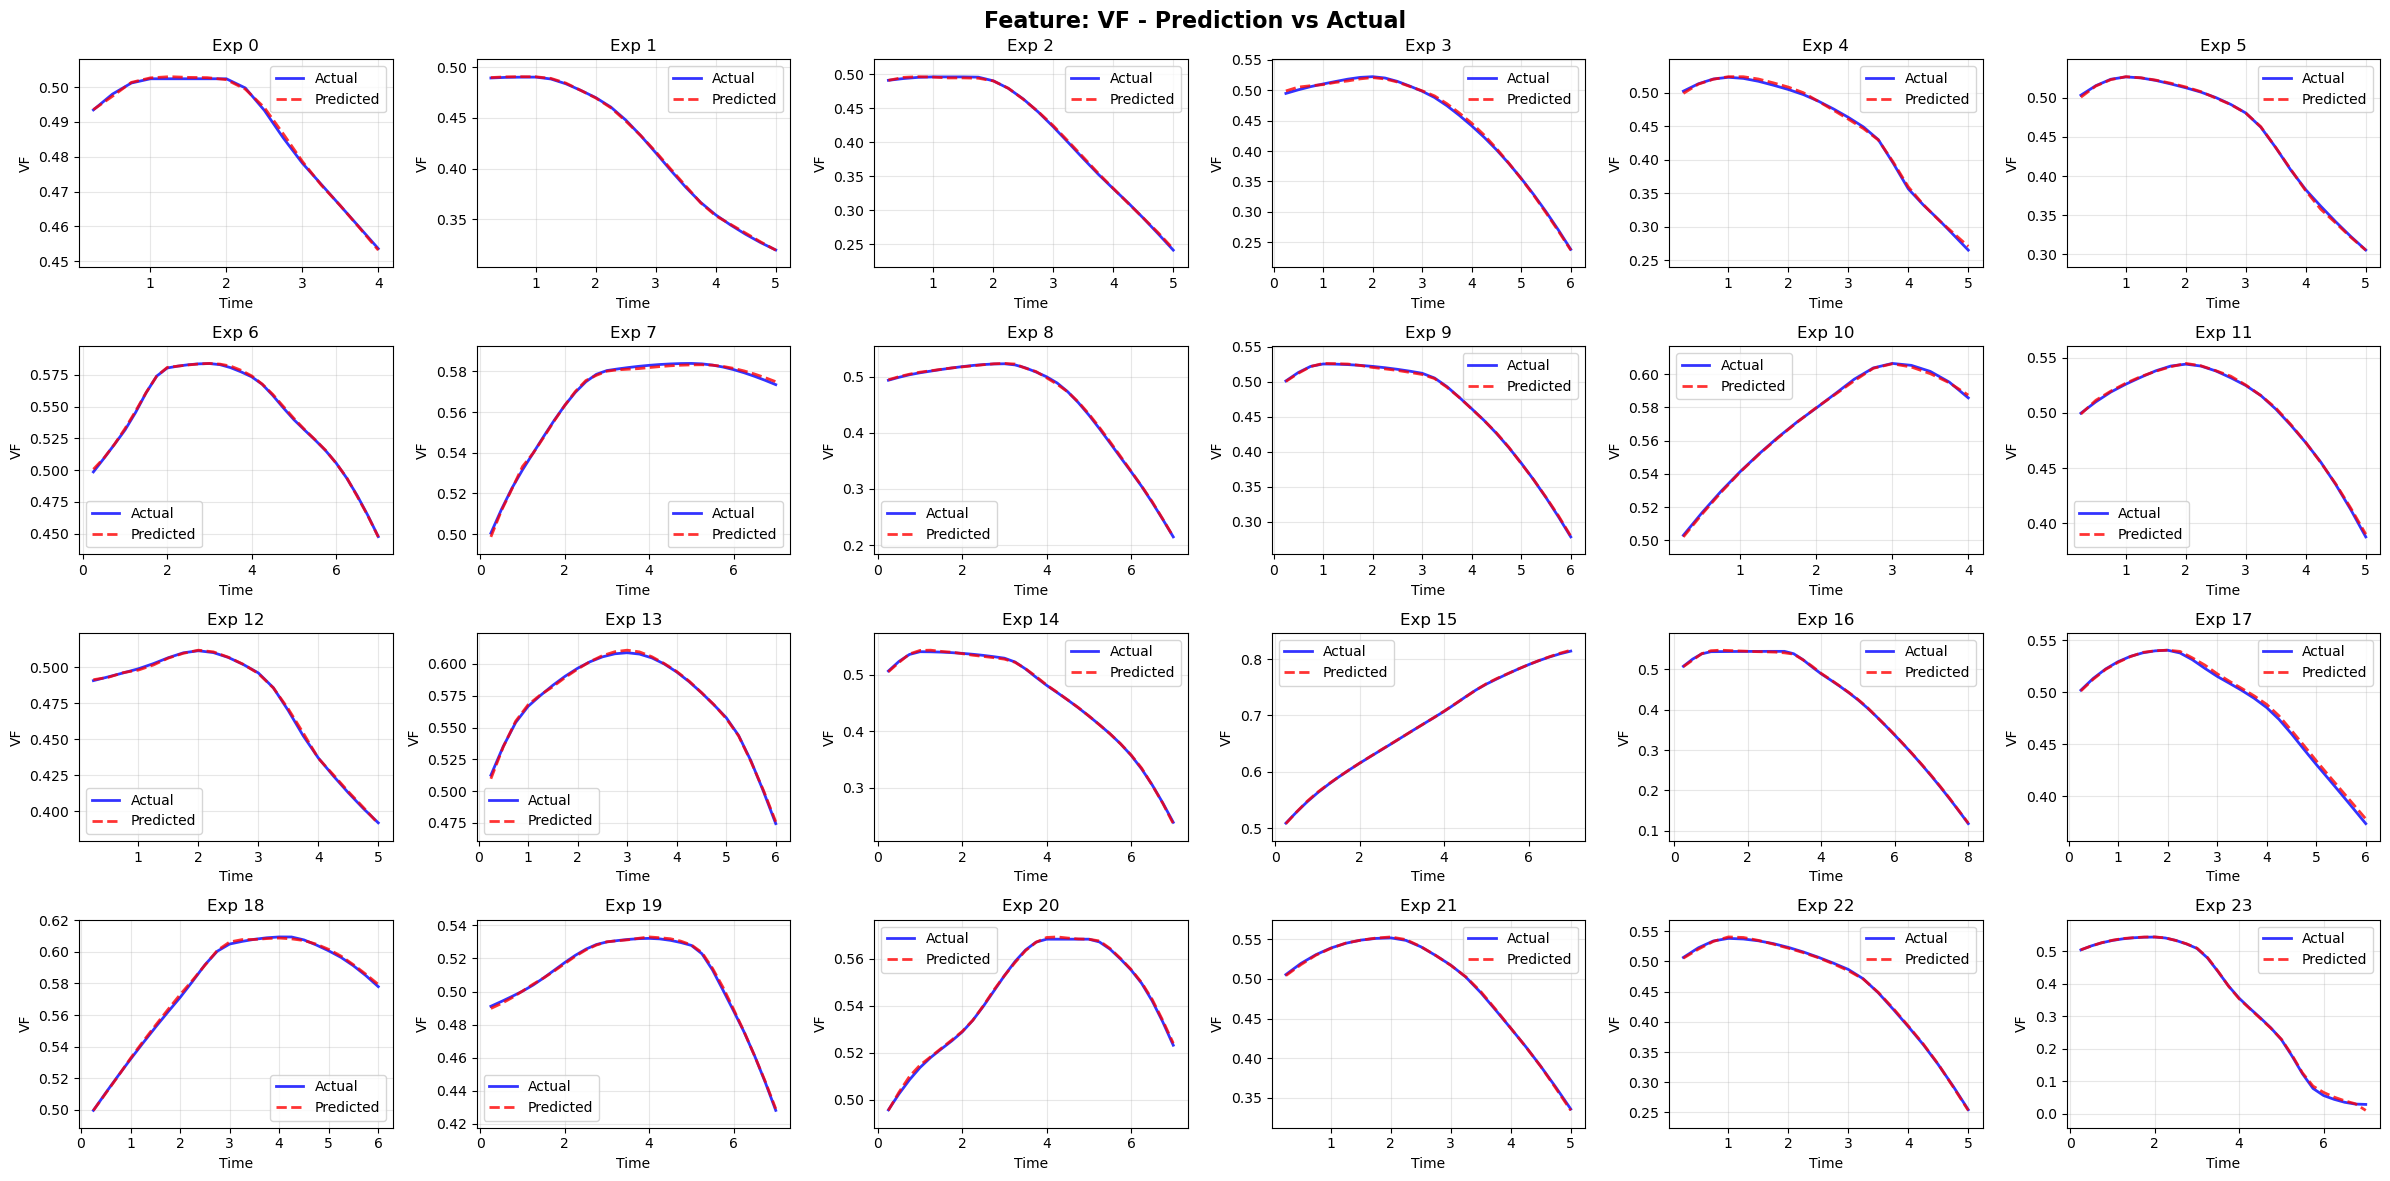

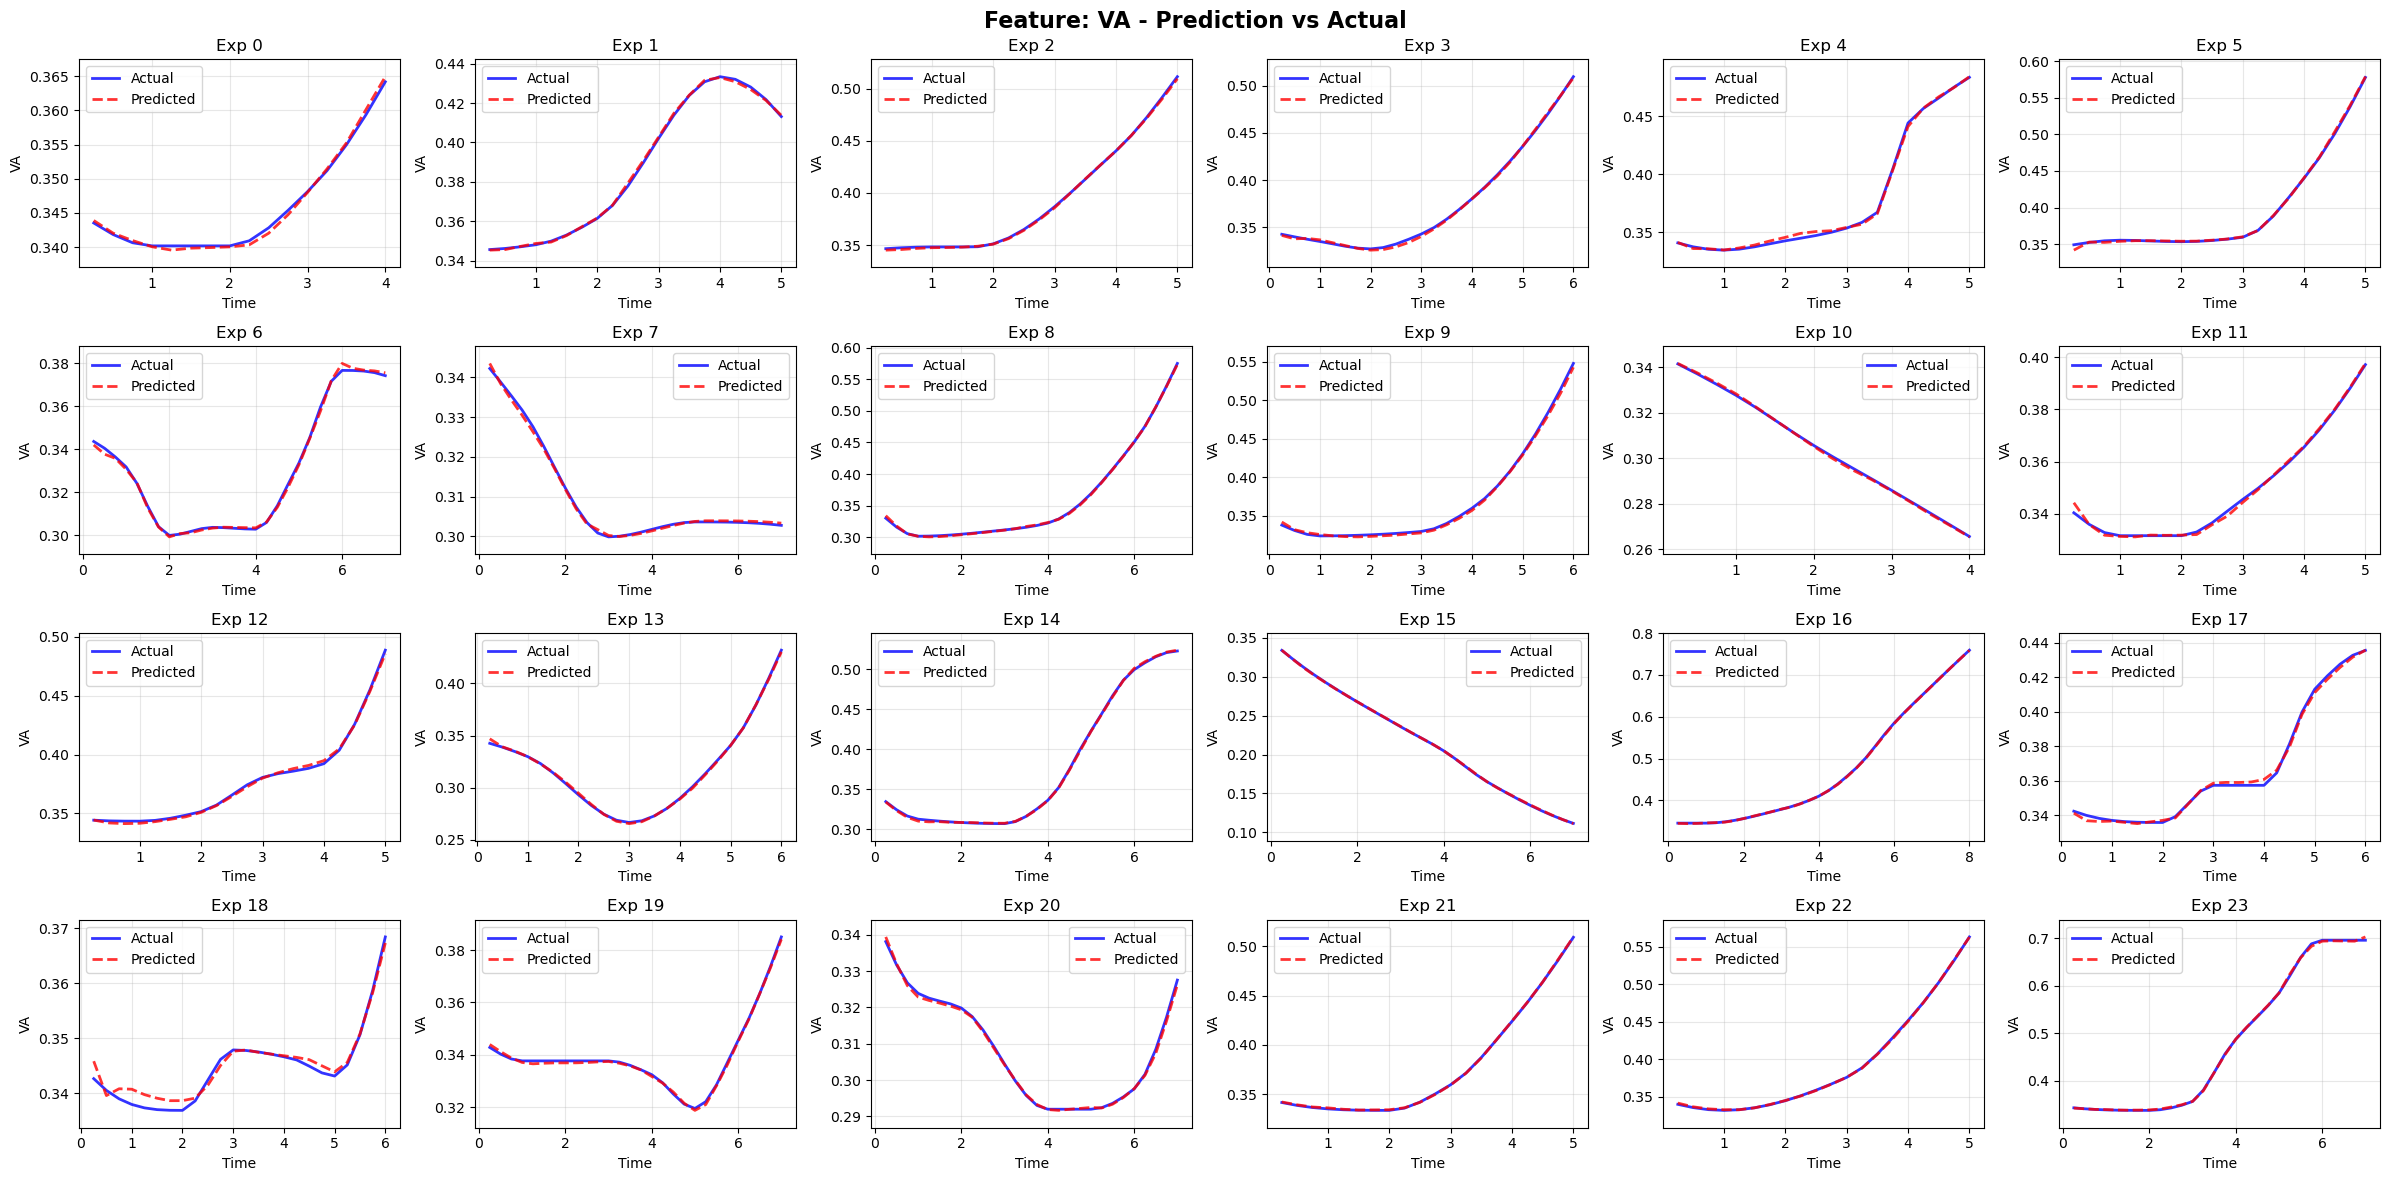

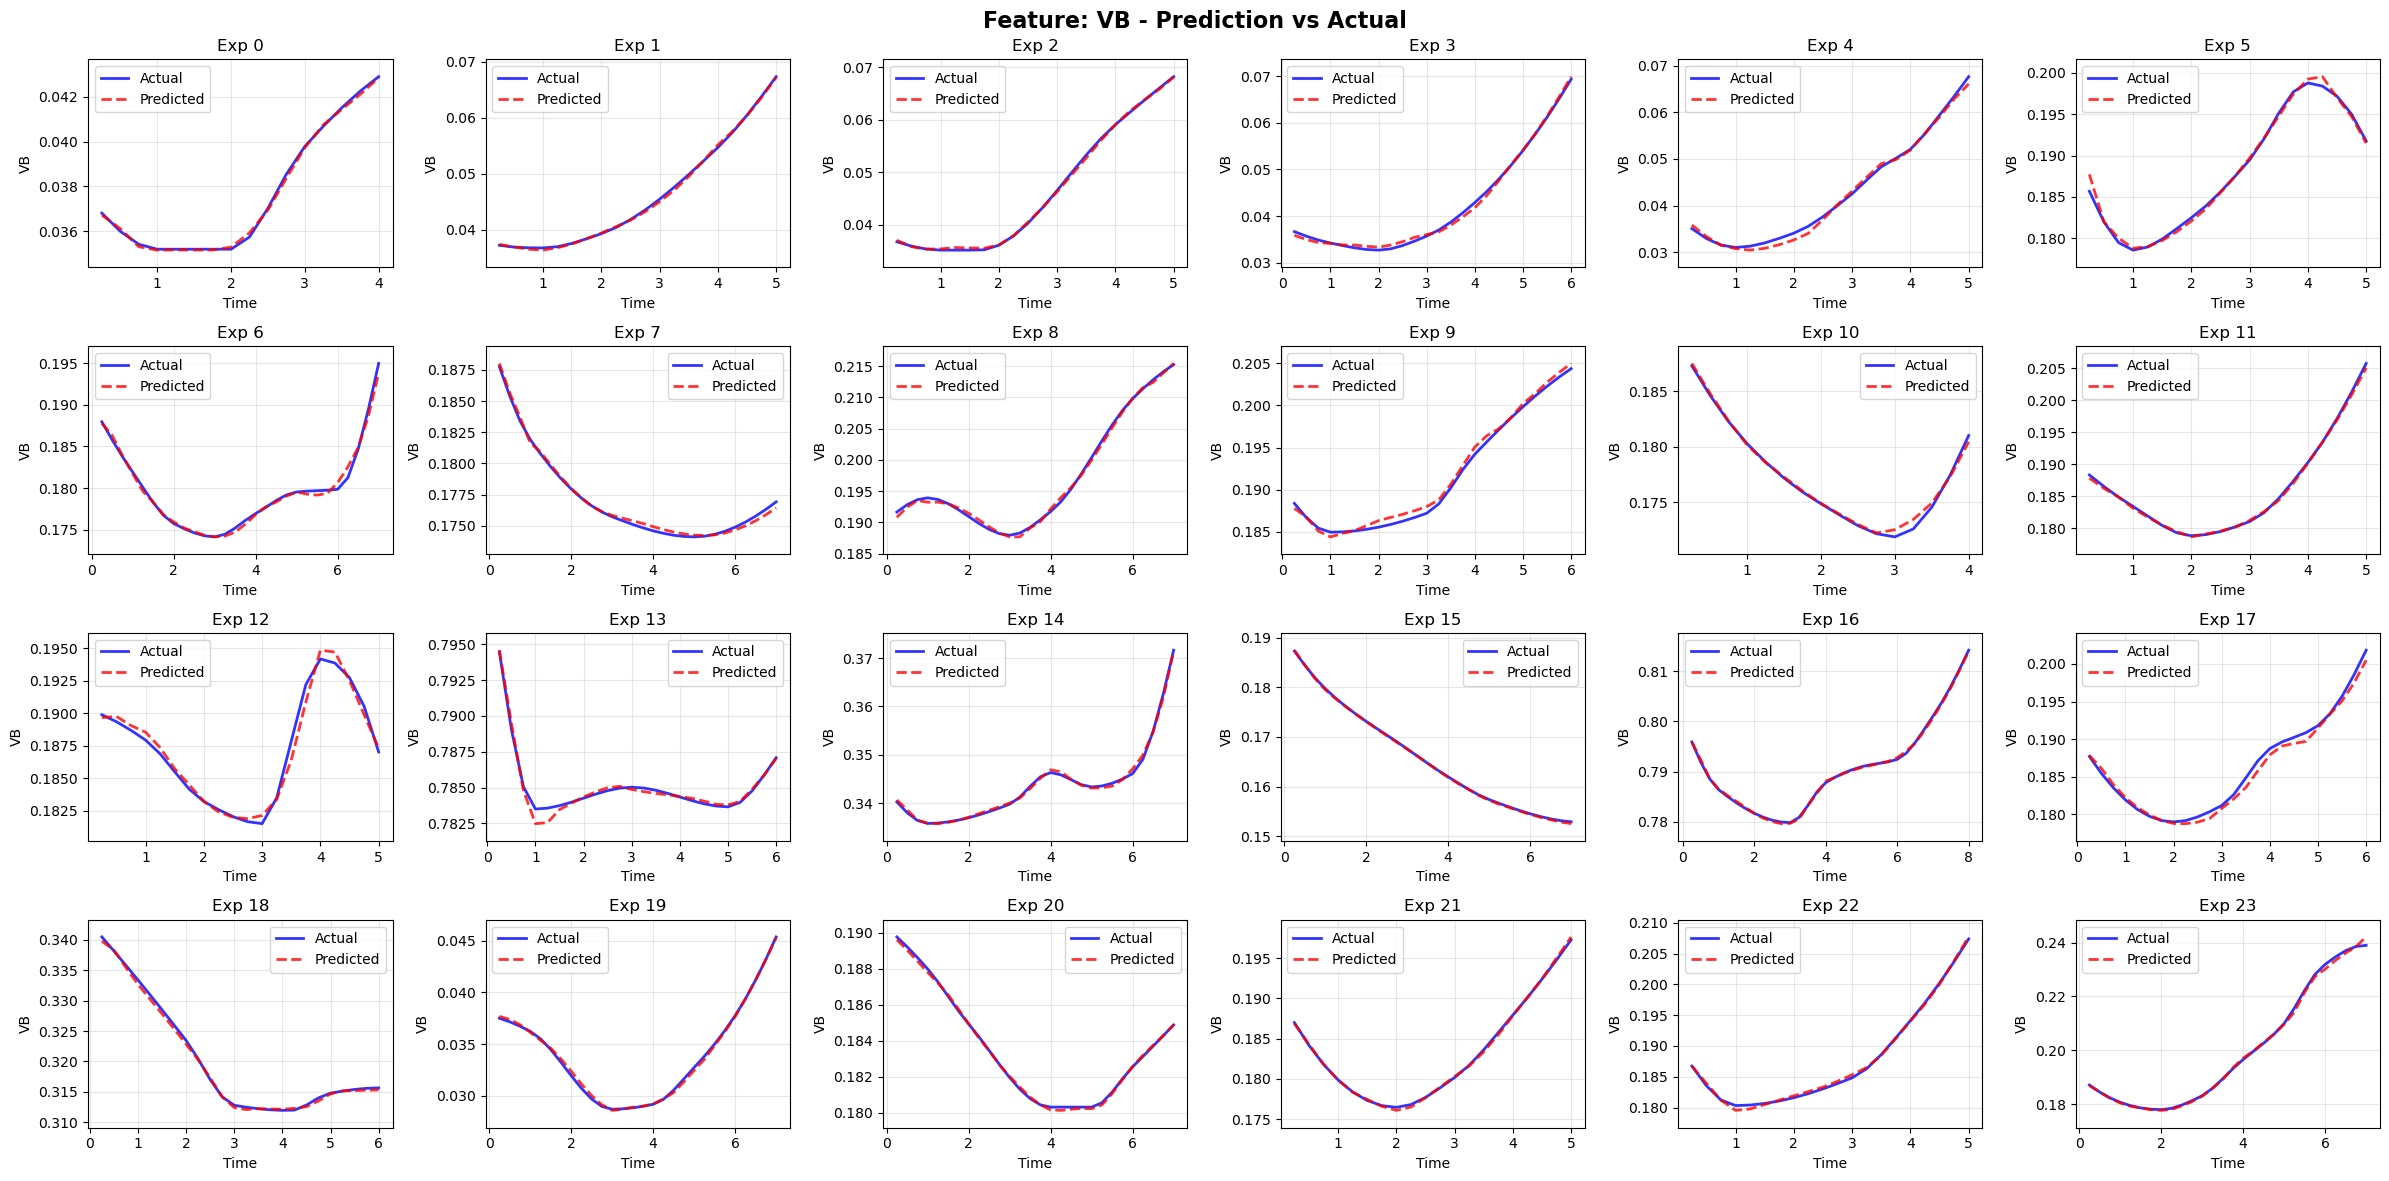

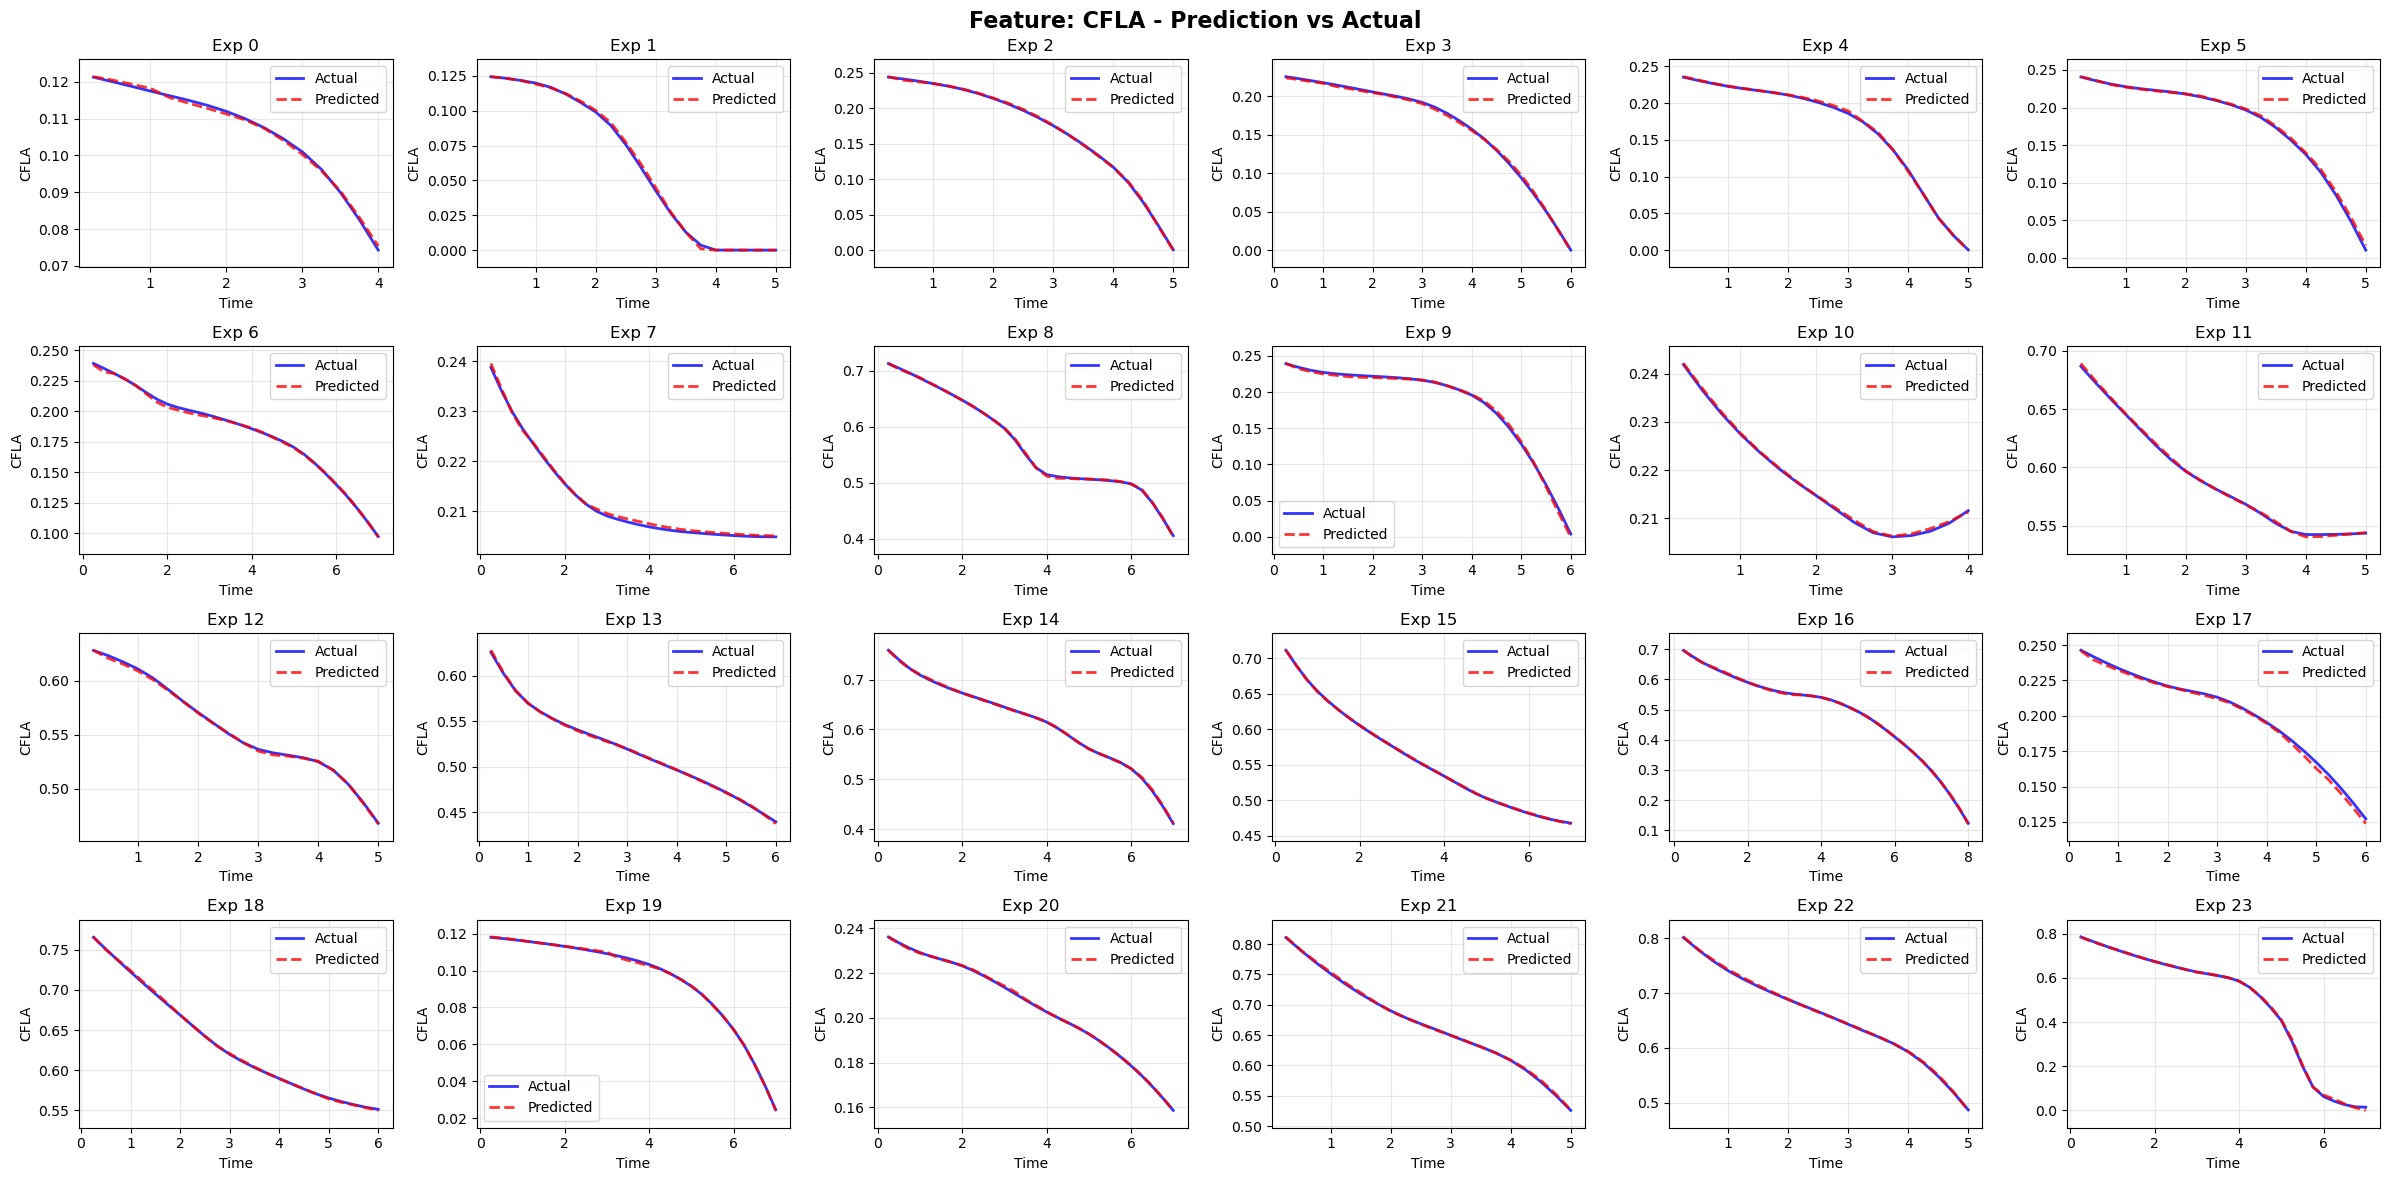

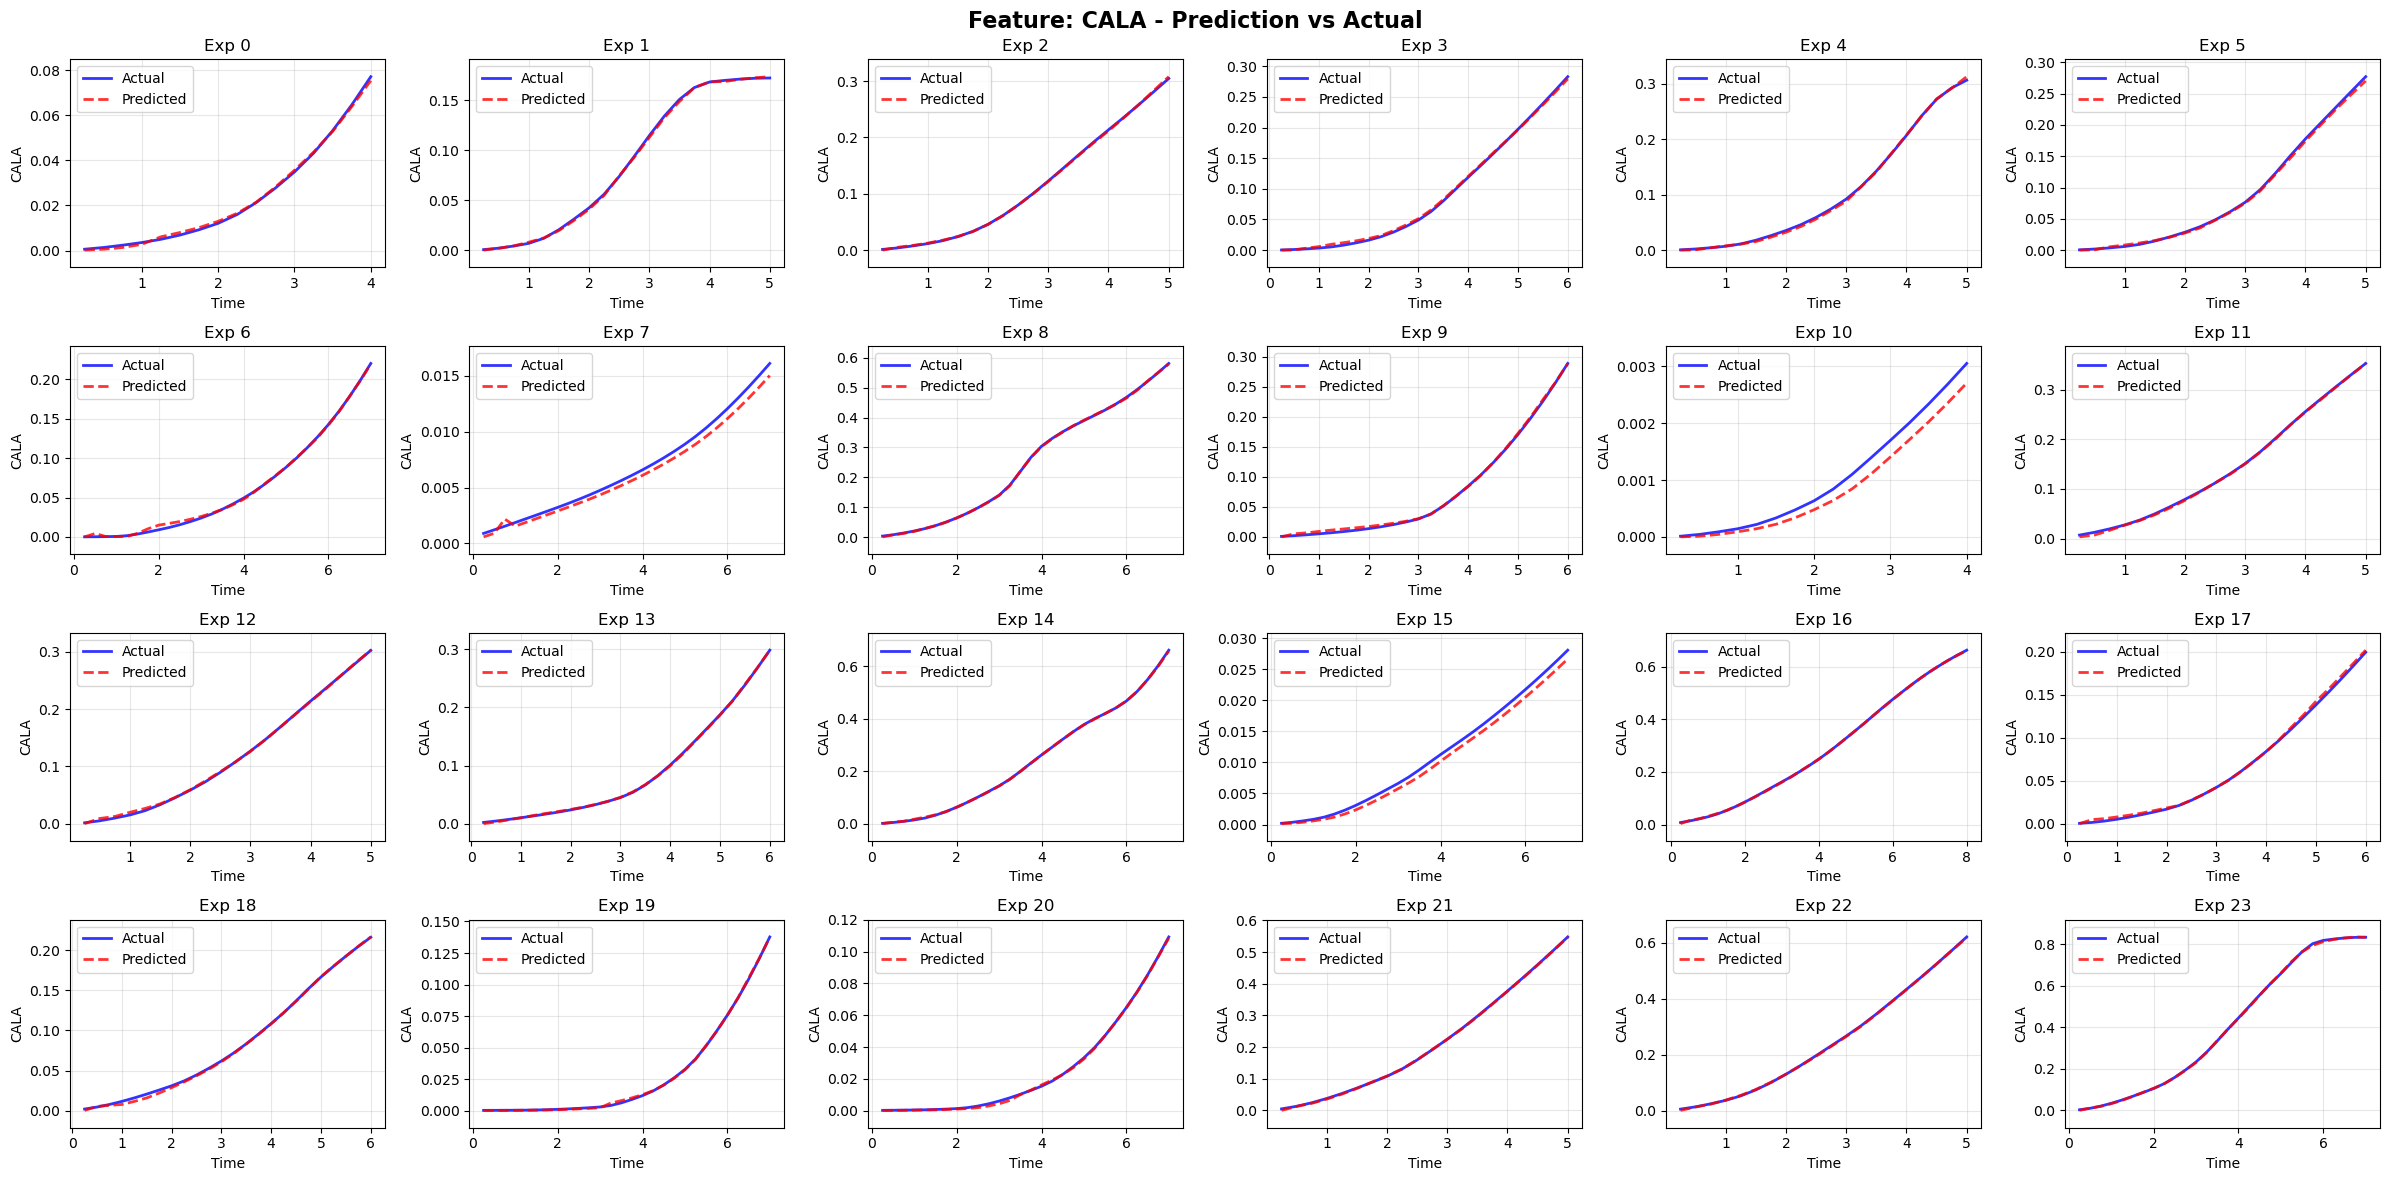

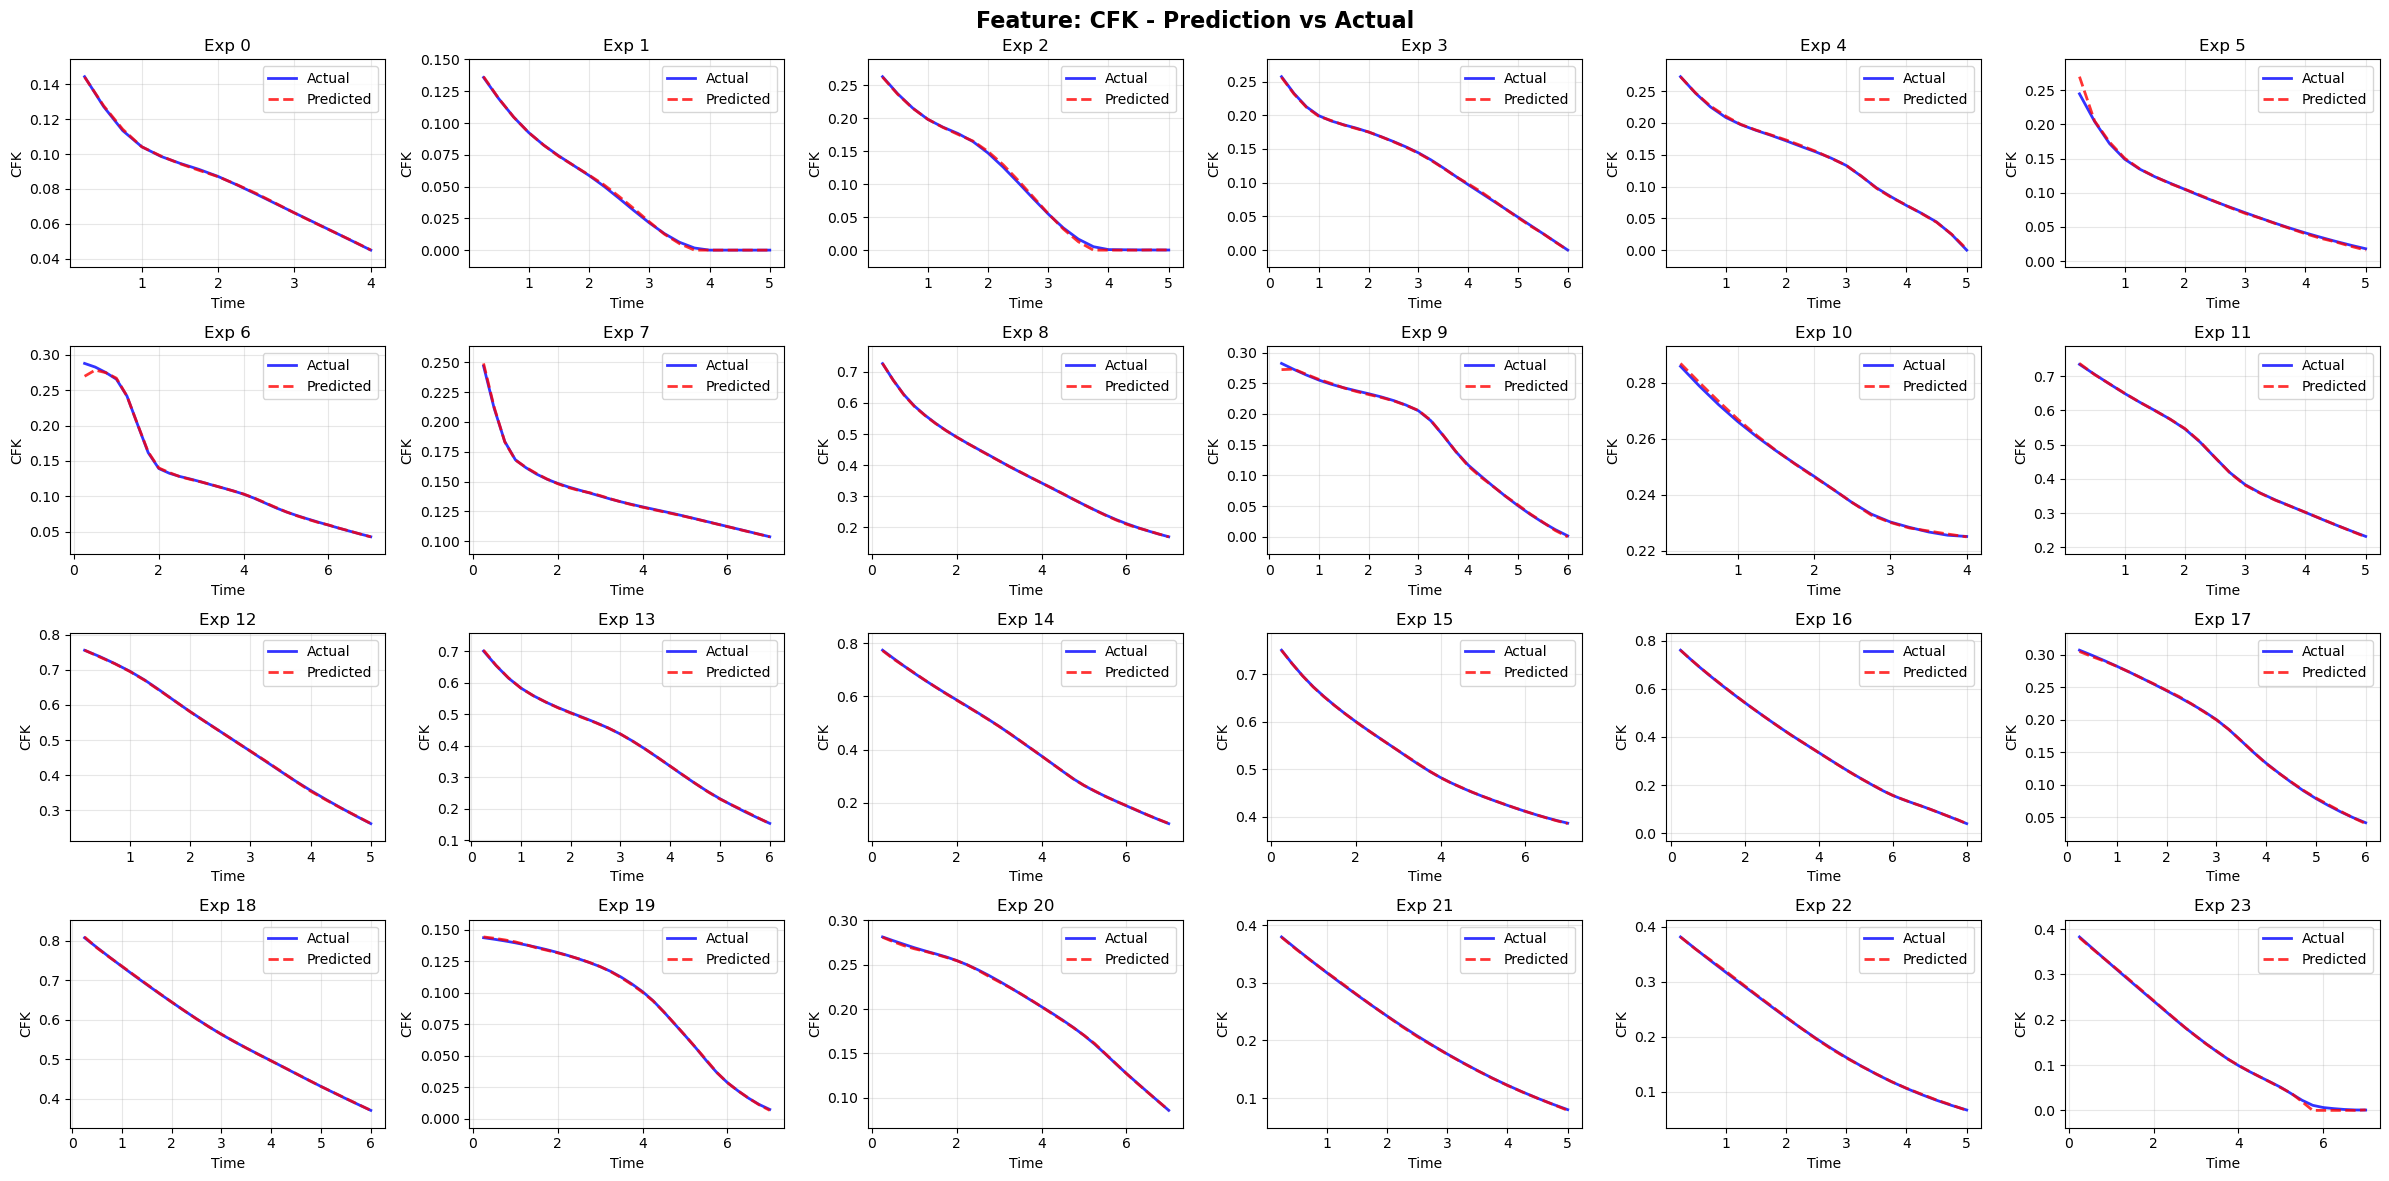

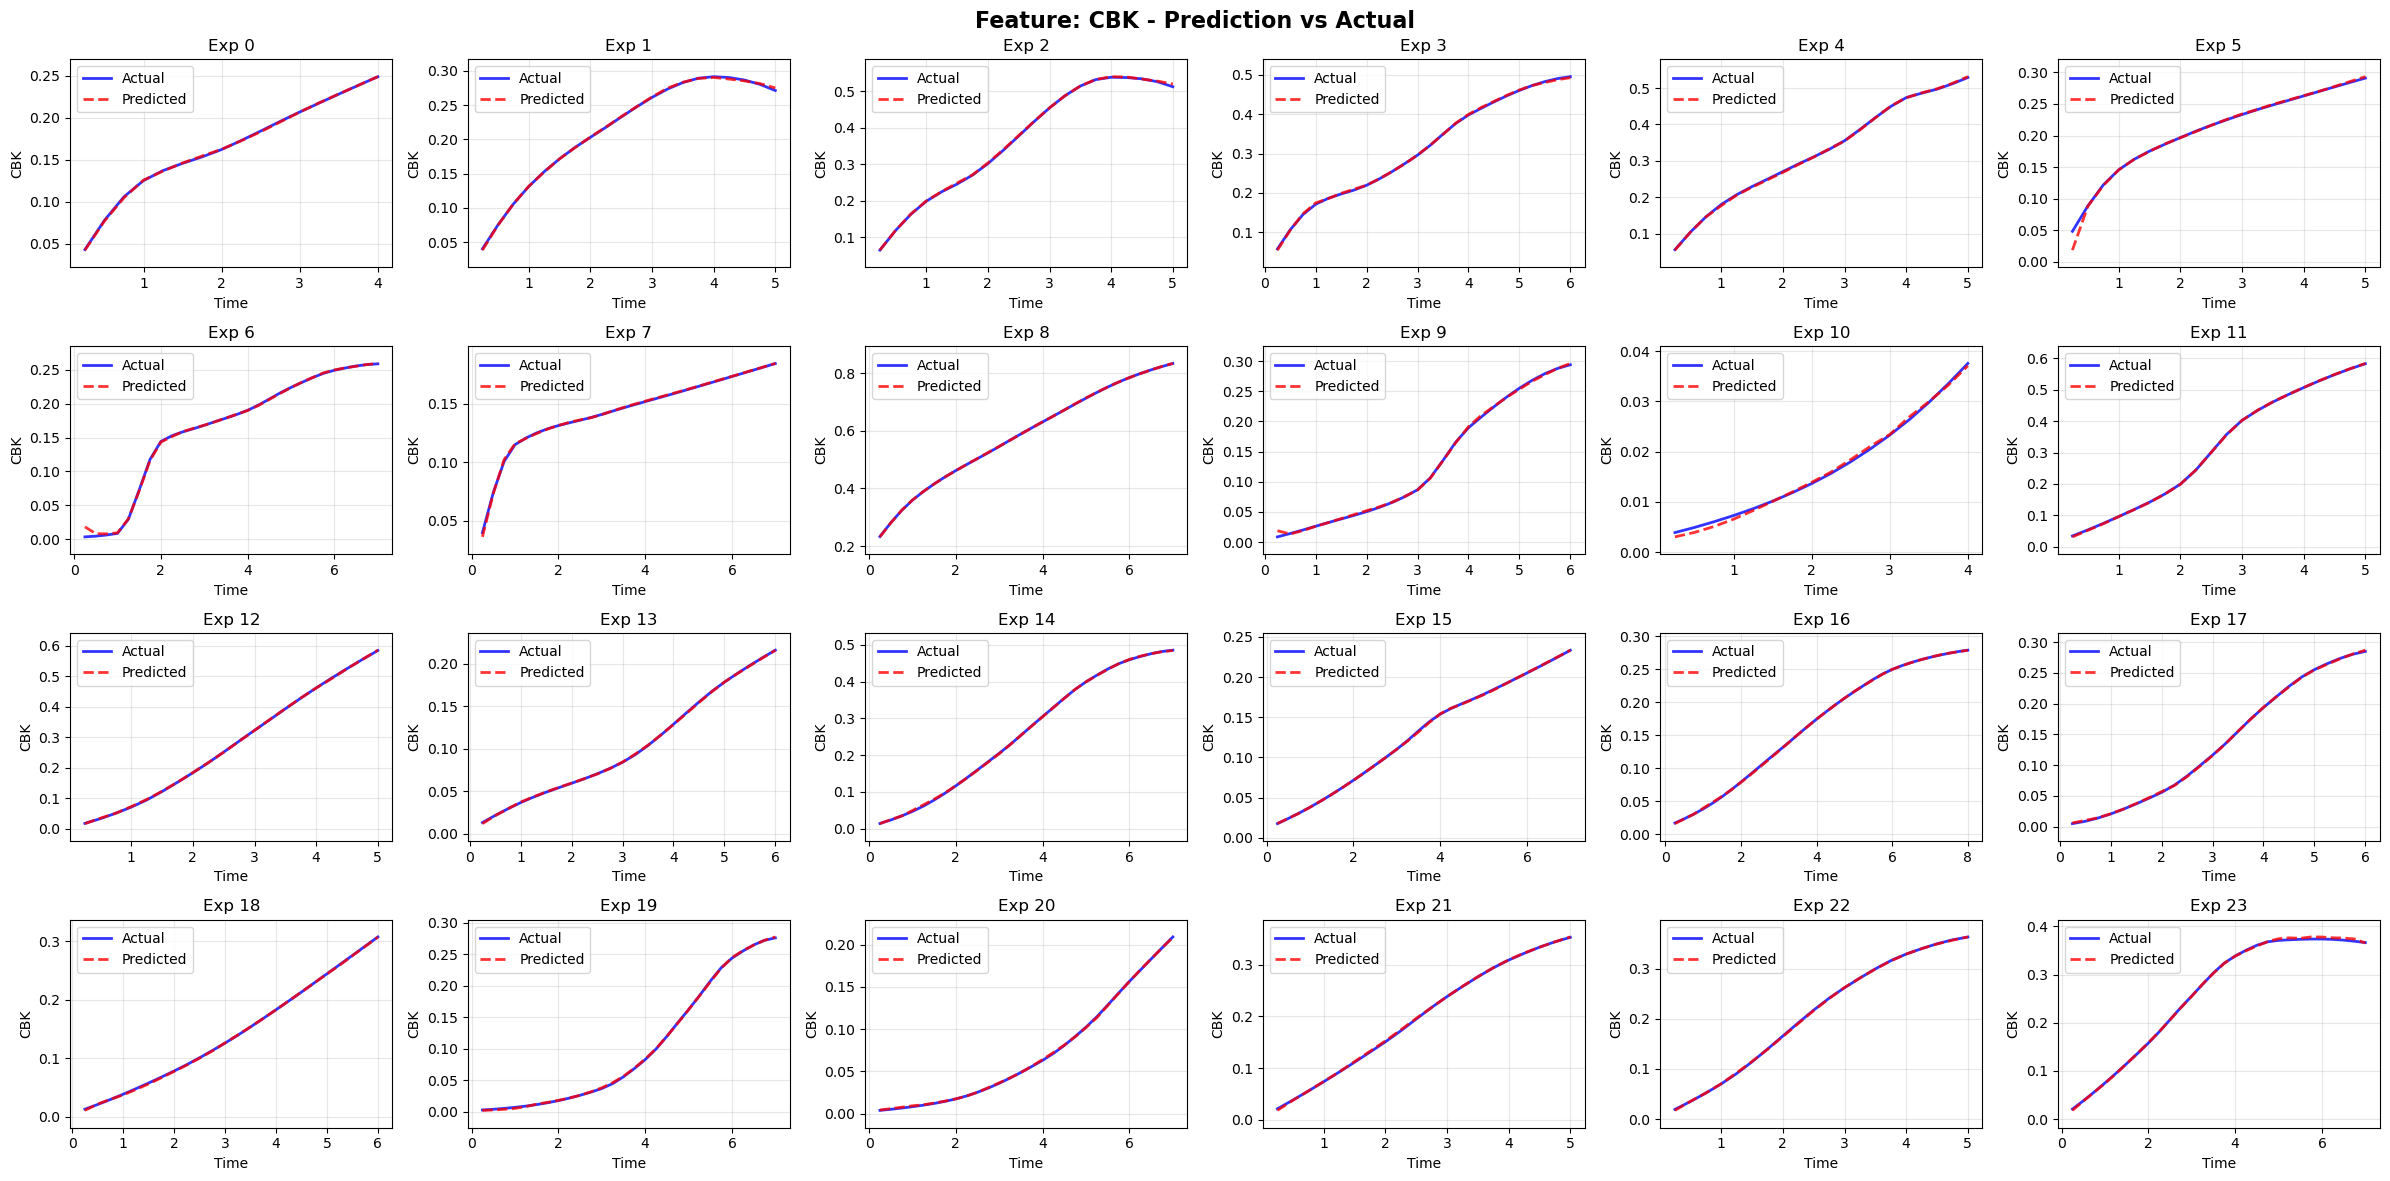

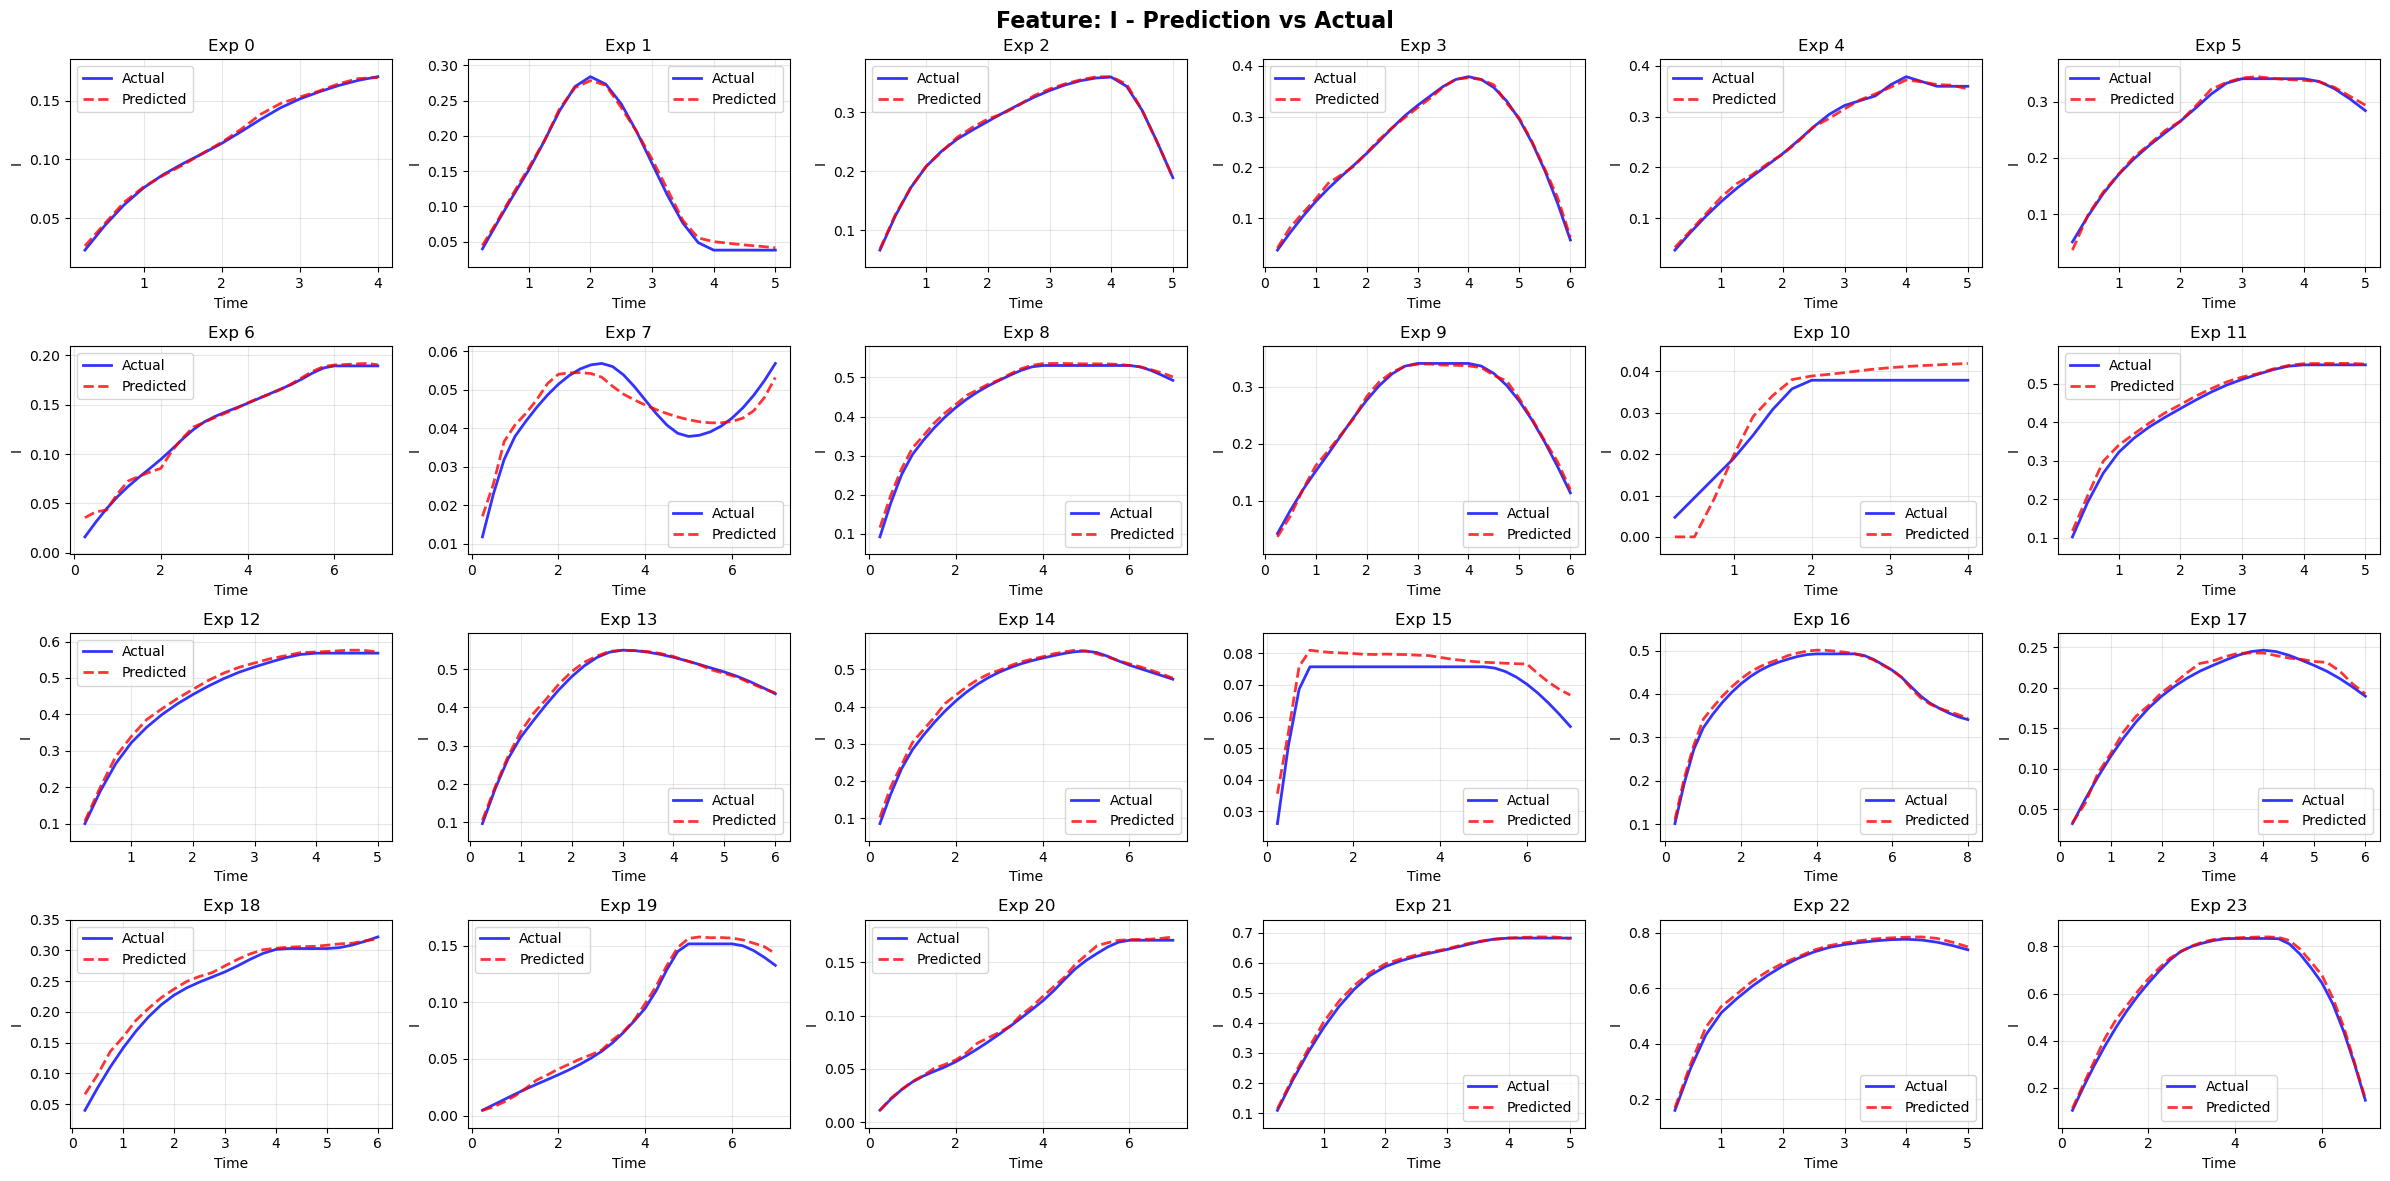

üéâ Î™®Îì† featureÏóê ÎåÄÌïú ÎπÑÍµê Í∑∏ÎûòÌîÑ ÏÉùÏÑ± ÏôÑÎ£å!
üìä Í∑∏ÎûòÌîÑ ÏÑ§Î™Ö:
   - ÌååÎûÄÏÉâ Ïã§ÏÑ†: Ïã§ÌóòÍ∞í (Actual)
   - Îπ®Í∞ÑÏÉâ Ï†êÏÑ†: ÏòàÏ∏°Í∞í (Predicted)
   - Í∞Å subplot: Í∞úÎ≥Ñ Ïã§Ìóò Í≤∞Í≥º
   - V, E Ï†úÏô∏Ìïú 8Í∞ú feature Î™®Îëê ÌëúÏãú


In [30]:
# Teacher Forcing ÏòàÏ∏° Î∞è Ïã§ÌóòÍ∞í ÎπÑÍµê Í∑∏ÎûòÌîÑ ÏÉùÏÑ±
print("üéØ Teacher Forcing ÏòàÏ∏° ÏàòÌñâ Î∞è ÎπÑÍµê Í∑∏ÎûòÌîÑ ÏÉùÏÑ±")
print("="*60)

# Î™®Îç∏ÏùÑ ÌèâÍ∞Ä Î™®ÎìúÎ°ú ÏÑ§Ï†ï
model.eval()

# ÏòàÏ∏° Í≤∞Í≥ºÏôÄ Ïã§Ï†ú Í∞íÏùÑ Ï†ÄÏû•Ìï† ÎîïÏÖîÎÑàÎ¶¨
predictions_dict = {}
actual_dict = {}

# VÏôÄ EÎ•º Ï†úÏô∏Ìïú featureÎì§Ïùò Ïù∏Îç±Ïä§ÏôÄ Ïù¥Î¶Ñ
feature_names = ['VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
feature_indices = [2, 3, 4, 5, 6, 7, 8, 9]  # V(0), E(1)Î•º Ï†úÏô∏Ìïú Ïù∏Îç±Ïä§

with torch.no_grad():
    for batch_idx, (batch_sequences, batch_seq_len) in enumerate(dataloader):
        batch_sequences = batch_sequences.to(device)
        batch_seq_len = batch_seq_len.to(device)
        
        # Teacher forcing Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ (ÎßàÏßÄÎßâ Ï†ÑÎ•òÍ∞í Ï†úÍ±∞Ìïú ÏûÖÎ†• ‚Üí Ï†ÑÏ≤¥ ÏÉÅÌÉú ÏòàÏ∏°)
        inputs, targets, target_seq_len = tf_data(batch_sequences, batch_seq_len)
        
        # Î™®Îç∏ ÏòàÏ∏° ÏàòÌñâ
        predictions = model(inputs, target_seq_len)
        
        # Î∞∞Ïπò ÎÇ¥ Í∞Å Ïã§ÌóòÏóê ÎåÄÌï¥ Ï≤òÎ¶¨
        for i in range(predictions.shape[0]):
            # Ïã§Ï†ú Ïã§Ìóò Î≤àÌò∏ Í≥ÑÏÇ∞
            exp_num = exp_num_list[batch_idx * dataloader.batch_size + i]
            
            # Ïã§Ï†ú ÏãúÌÄÄÏä§ Í∏∏Ïù¥ Í∞ÄÏ†∏Ïò§Í∏∞
            actual_len = target_seq_len[i].item()
            
            # ÏòàÏ∏°Í∞íÍ≥º Ïã§Ï†úÍ∞í Ï†ÄÏû• (Ï†ïÍ∑úÌôîÎêú ÏÉÅÌÉú)
            pred_seq = predictions[i, :actual_len, :].cpu().numpy()
            actual_seq = targets[i, :actual_len, :].cpu().numpy()
            
            predictions_dict[exp_num] = pred_seq
            actual_dict[exp_num] = actual_seq

print(f"‚úÖ {len(predictions_dict)}Í∞ú Ïã§ÌóòÏóê ÎåÄÌïú ÏòàÏ∏° ÏôÑÎ£å")

# VÏôÄ EÎ•º Ï†úÏô∏Ìïú Í∞Å featureÎ≥ÑÎ°ú Í∑∏ÎûòÌîÑ ÏÉùÏÑ±
for feat_idx, feat_name in zip(feature_indices, feature_names):
    # subplot Í∞úÏàò Í≥ÑÏÇ∞ (ÌñâÍ≥º Ïó¥ ÏµúÏ†ÅÌôî)
    n_experiments = len(exp_num_list)
    n_cols = min(6, n_experiments)  # ÏµúÎåÄ 6Ïó¥
    n_rows = (n_experiments + n_cols - 1) // n_cols  # ÌïÑÏöîÌïú Ìñâ Ïàò
    
    # Í∑∏ÎûòÌîÑ ÌÅ¨Í∏∞ ÏÑ§Ï†ï
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    fig.suptitle(f'Feature: {feat_name} - Prediction vs Actual', fontsize=16, fontweight='bold')
    
    # subplotÏù¥ 1Í∞úÏùº Í≤ΩÏö∞ Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôò
    if n_experiments == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Í∞Å Ïã§ÌóòÏóê ÎåÄÌï¥ subplot ÏÉùÏÑ±
    for i, exp_num in enumerate(exp_num_list):
        row = i // n_cols
        col = i % n_cols
        
        if n_rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col] if n_cols > 1 else axes[0]
        
        # Ìï¥Îãπ Ïã§ÌóòÏùò ÏãúÍ∞Ñ Îç∞Ïù¥ÌÑ∞ Í∞ÄÏ†∏Ïò§Í∏∞
        exp_data = df[df['exp'] == exp_num]
        time_points = exp_data['t'].values[1:]  # Ï≤´ Î≤àÏß∏ ÏãúÏ†ê Ï†úÏô∏ (teacher forcing)
        
        # ÏòàÏ∏°Í∞íÍ≥º Ïã§Ï†úÍ∞í Í∞ÄÏ†∏Ïò§Í∏∞
        if exp_num in predictions_dict:
            pred_values = predictions_dict[exp_num][:, feat_idx]
            actual_values = actual_dict[exp_num][:, feat_idx]
            
            # ÏãúÍ∞Ñ Ï∂ï Ï°∞Ï†ï (ÏòàÏ∏° Í∏∏Ïù¥Ïóê ÎßûÏ∂∞)
            time_adjusted = time_points[:len(pred_values)]
            
            # Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
            ax.plot(time_adjusted, actual_values, 'b-', linewidth=2, label='Actual', alpha=0.8)
            ax.plot(time_adjusted, pred_values, 'r--', linewidth=2, label='Predicted', alpha=0.8)
            
            # Í∑∏ÎûòÌîÑ ÏÑ§Ï†ï
            ax.set_title(f'Exp {exp_num}', fontsize=12)
            ax.set_xlabel('Time')
            ax.set_ylabel(feat_name)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=10)
            
            # yÏ∂ï Î≤îÏúÑ ÏÑ§Ï†ï (Ïã§Ï†úÍ∞í Í∏∞Ï§Ä)
            y_min, y_max = min(actual_values.min(), pred_values.min()), max(actual_values.max(), pred_values.max())
            y_range = y_max - y_min
            ax.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
        else:
            ax.text(0.5, 0.5, f'No data\nExp {exp_num}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Îπà subplot Ï†úÍ±∞
    for i in range(n_experiments, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        if n_rows > 1:
            axes[row, col].remove()
        else:
            if n_cols > 1:
                axes[col].remove()
    
    plt.tight_layout()
    plt.show()

print("üéâ Î™®Îì† featureÏóê ÎåÄÌïú ÎπÑÍµê Í∑∏ÎûòÌîÑ ÏÉùÏÑ± ÏôÑÎ£å!")
print("üìä Í∑∏ÎûòÌîÑ ÏÑ§Î™Ö:")
print("   - ÌååÎûÄÏÉâ Ïã§ÏÑ†: Ïã§ÌóòÍ∞í (Actual)")
print("   - Îπ®Í∞ÑÏÉâ Ï†êÏÑ†: ÏòàÏ∏°Í∞í (Predicted)")
print("   - Í∞Å subplot: Í∞úÎ≥Ñ Ïã§Ìóò Í≤∞Í≥º")
print("   - V, E Ï†úÏô∏Ìïú 8Í∞ú feature Î™®Îëê ÌëúÏãú")